# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

From a data science perspective, our task is to develop a regression modeling framework to quantify the factors that significantly influence used vehicle pricing. We will conduct multivariate analysis to identify the key predictive features, implement feature engineering to transform raw vehicle attributes, and build multiple regression models with hyperparameter optimization to accurately estimate price determinants. The project requires evaluating model performance using appropriate error metrics (RMSE, MAE, R²) and interpreting feature importance or coefficients to translate statistical findings into actionable business insights on price drivers.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Key Elements of the Data Exploration
1. Dataset Structure Analysis
The exploration begins by examining the basic structure of the dataset (229,734 rows and 18 columns), identifying data types, and reviewing sample data to get a general understanding of what information is available for analysis.
2. Data Quality Assessment
The code identifies key quality issues including:

Missing values in multiple columns
Potential outliers in price and odometer readings
Duplicate entries
Inconsistent formatting in categorical variables

In [70]:
# Set visualization styles for better readability
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# -------------------- 1. Load and Inspect Data --------------------
# Load the dataset
print("Loading and inspecting the vehicles dataset...")
df = pd.read_csv('data/vehicles.csv')

# Display basic information about the dataset
print(f"\nDataset Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)

# Show the first few rows
print("\nFirst 5 rows:")
print(df.head())



Loading and inspecting the vehicles dataset...

Dataset Shape: (426880, 18)

Data Types:
id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object

First 5 rows:
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition

In [ ]:
# --------------------  Data Quality Assessment --------------------
# Check for missing values
print("\nMissing Values Analysis:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
}).sort_values('Percentage', ascending=False)

print(missing_df[missing_df['Missing Values'] > 0])

# Examine duplicate entries
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Check for outliers in numerical columns
print("\nBasic Statistics for Numerical Columns:")
print(df[['price', 'year', 'odometer']].describe())


Missing Values Analysis:
              Missing Values  Percentage
size                  306361       71.77
cylinders             177678       41.62
condition             174104       40.79
VIN                   161042       37.73
drive                 130567       30.59
paint_color           130203       30.50
type                   92858       21.75
manufacturer           17646        4.13
title_status            8242        1.93
model                   5277        1.24
odometer                4400        1.03
fuel                    3013        0.71
transmission            2556        0.60
year                    1205        0.28

Number of duplicate rows: 0

Basic Statistics for Numerical Columns:
              price           year      odometer
count  4.268800e+05  425675.000000  4.224800e+05
mean   7.519903e+04    2011.235191  9.804333e+04
std    1.218228e+07       9.452120  2.138815e+05
min    0.000000e+00    1900.000000  0.000000e+00
25%    5.900000e+03    2008.000000  3.770400

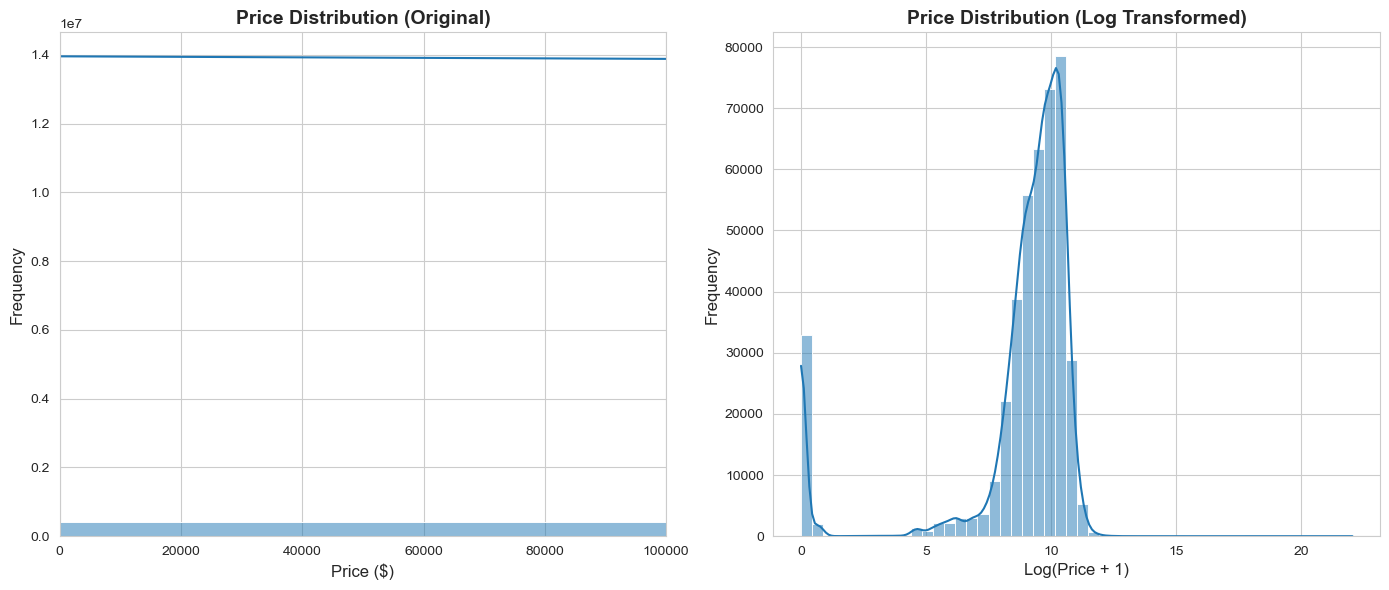

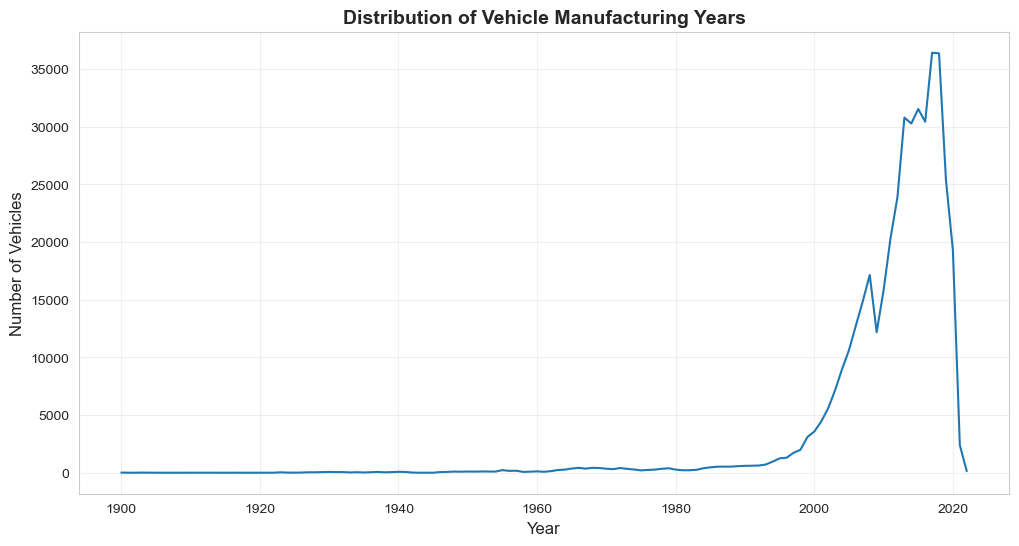

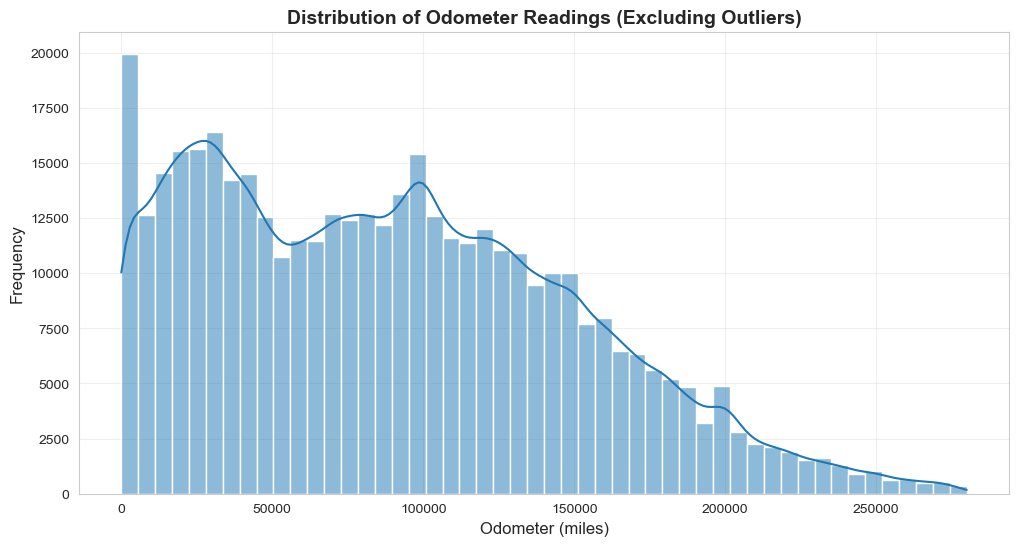

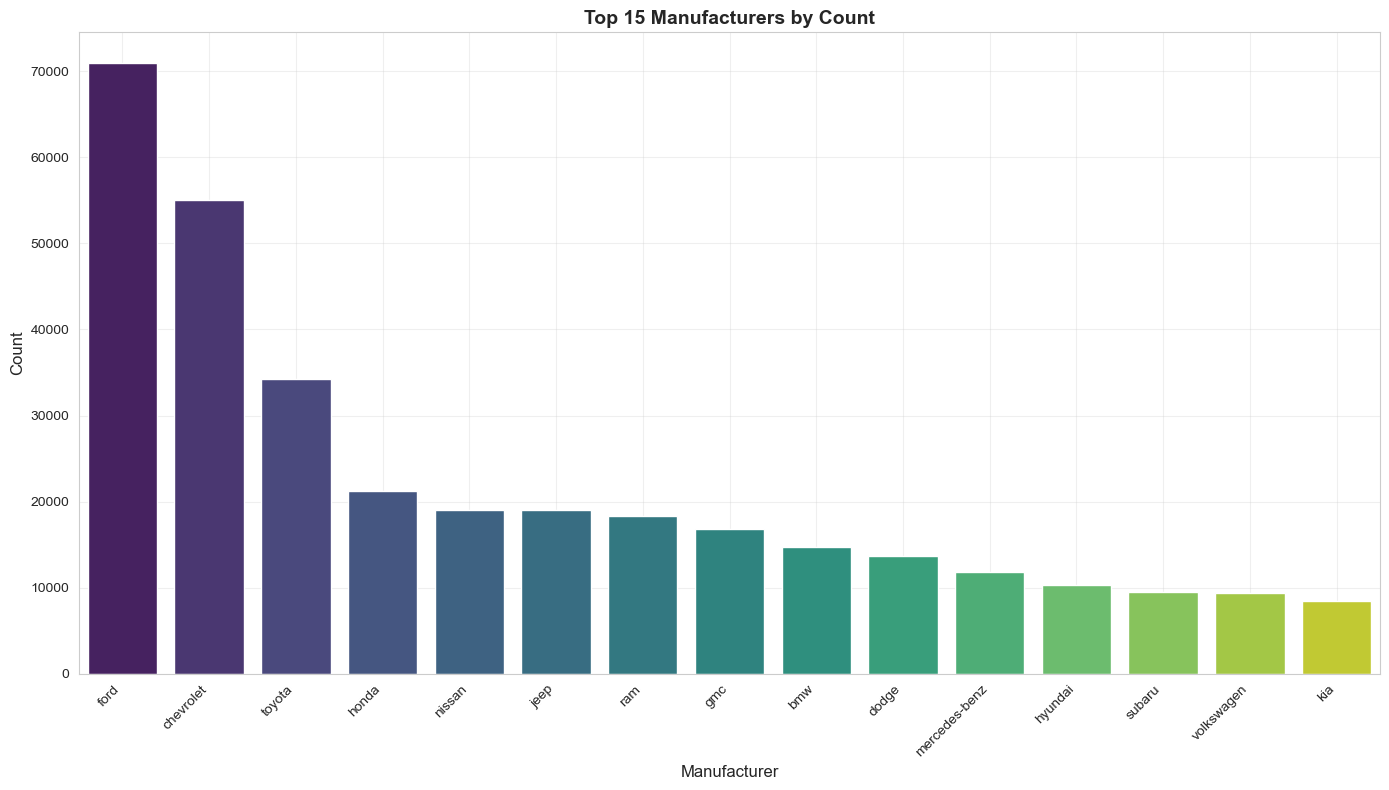

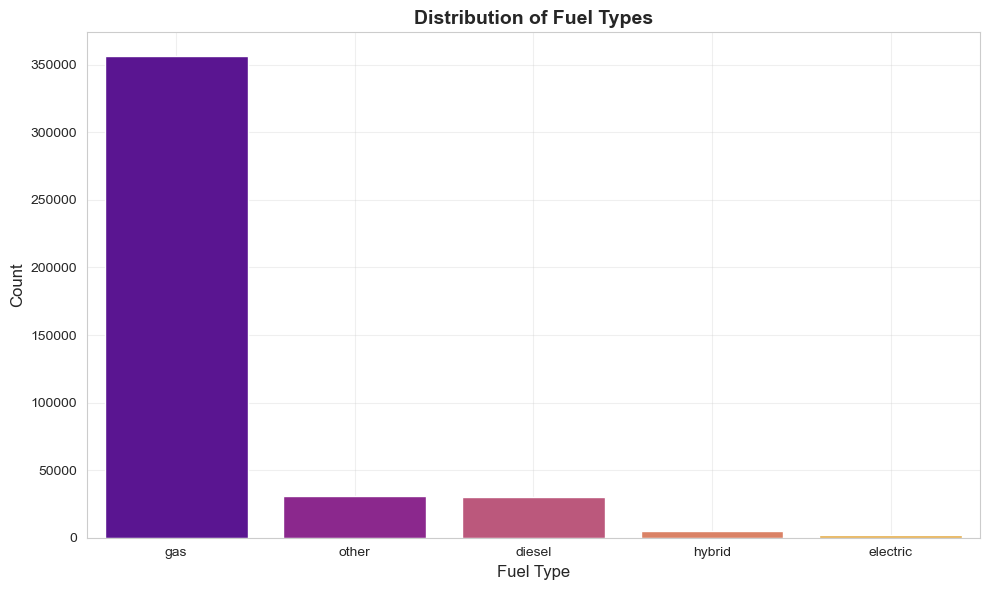

In [ ]:
# --------------------  Univariate Analysis --------------------
# Distribution of prices (target variable)
plt.figure(figsize=(14, 6))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['price'].dropna(), kde=True, bins=50)
plt.title('Price Distribution (Original)', fontweight='bold')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
# Limit x-axis to focus on main distribution
plt.xlim(0, 100000)

# Log-transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['price'].dropna()), kde=True, bins=50)
plt.title('Price Distribution (Log Transformed)', fontweight='bold')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')

plt.tight_layout()

# Distribution of year (vehicle age)
plt.figure(figsize=(12, 6))
year_counts = df['year'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values)
plt.title('Distribution of Vehicle Manufacturing Years', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.grid(True, alpha=0.3)


# Distribution of odometer readings
plt.figure(figsize=(12, 6))
# Drop the outliers for better visualization
odometer_filtered = df['odometer'].dropna()
odometer_filtered = odometer_filtered[odometer_filtered < odometer_filtered.quantile(0.99)]

sns.histplot(odometer_filtered, kde=True, bins=50)
plt.title('Distribution of Odometer Readings (Excluding Outliers)', fontweight='bold')
plt.xlabel('Odometer (miles)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)


# Explore top manufacturers
plt.figure(figsize=(14, 8))
top_manufacturers = df['manufacturer'].value_counts().head(15)
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values, palette='viridis')
plt.title('Top 15 Manufacturers by Count', fontweight='bold')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()


# Distribution of fuel types
plt.figure(figsize=(10, 6))
fuel_counts = df['fuel'].value_counts()
sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette='plasma')
plt.title('Distribution of Fuel Types', fontweight='bold')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()


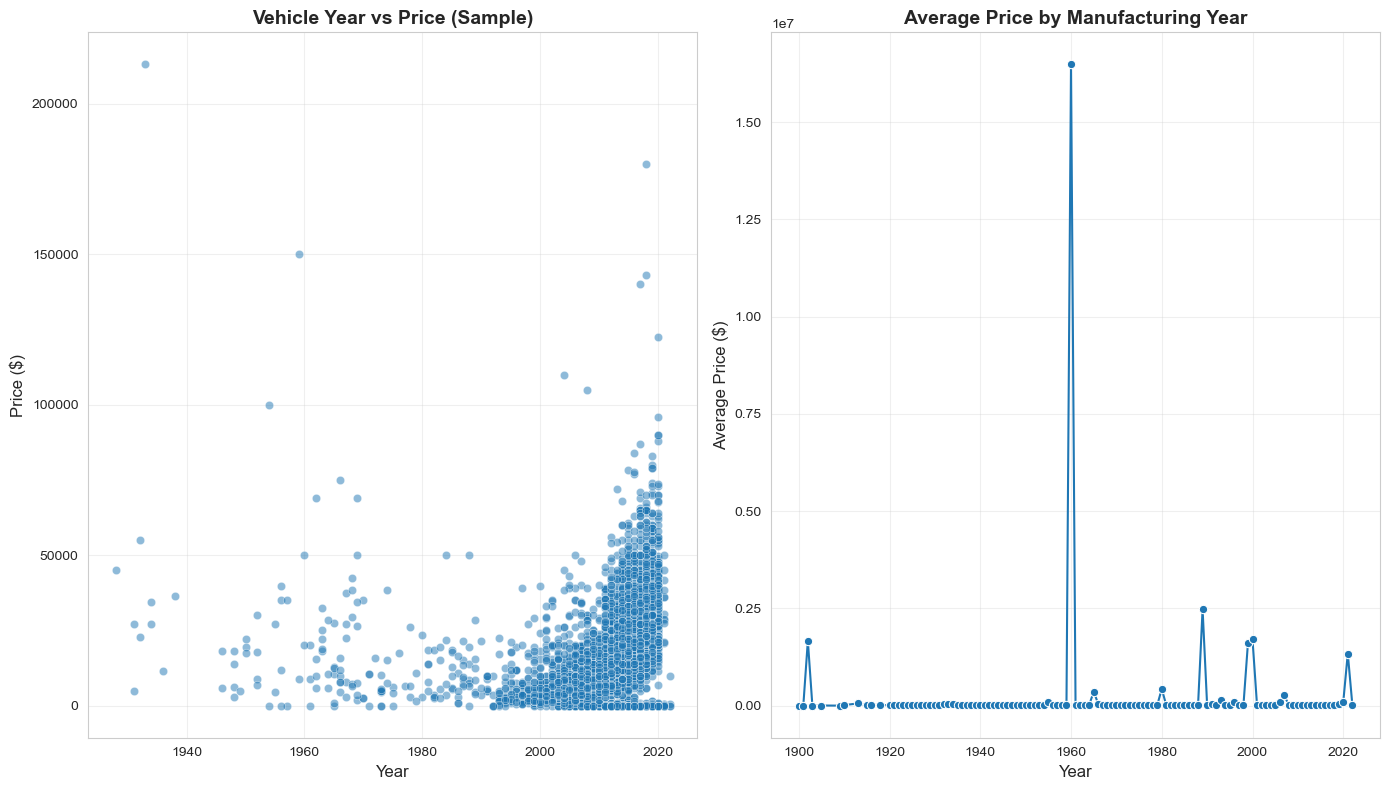

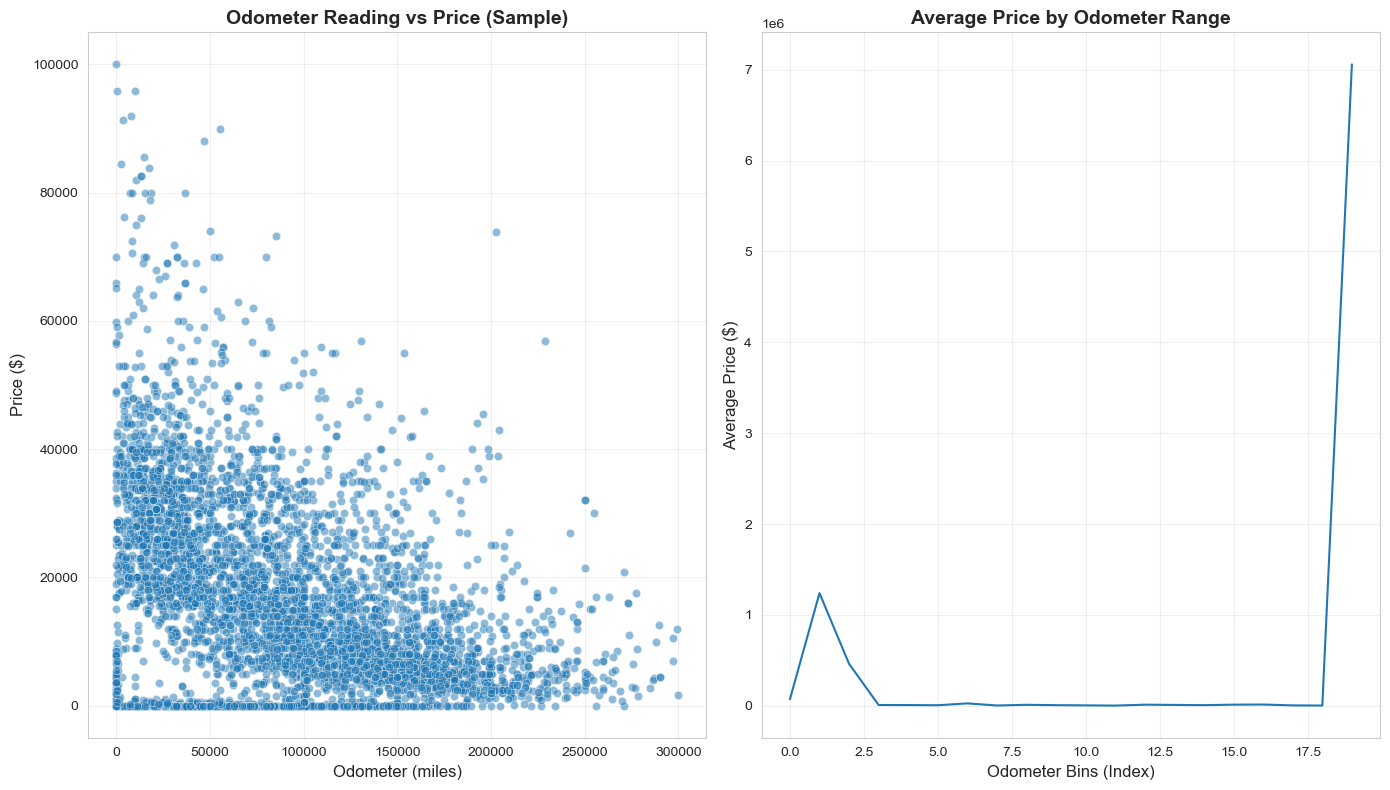

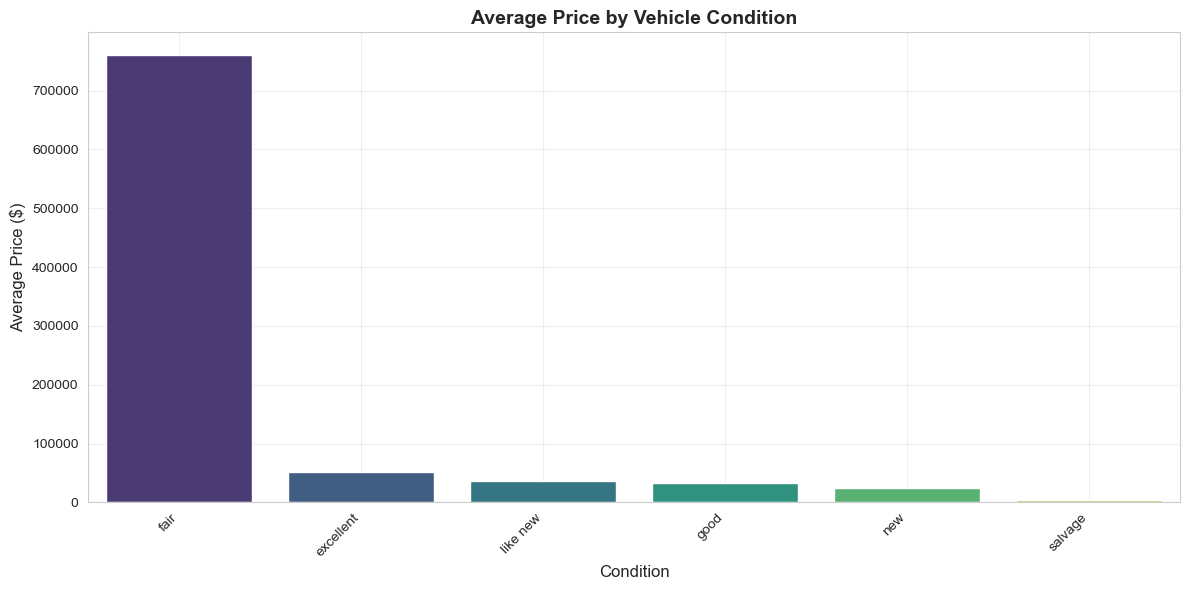

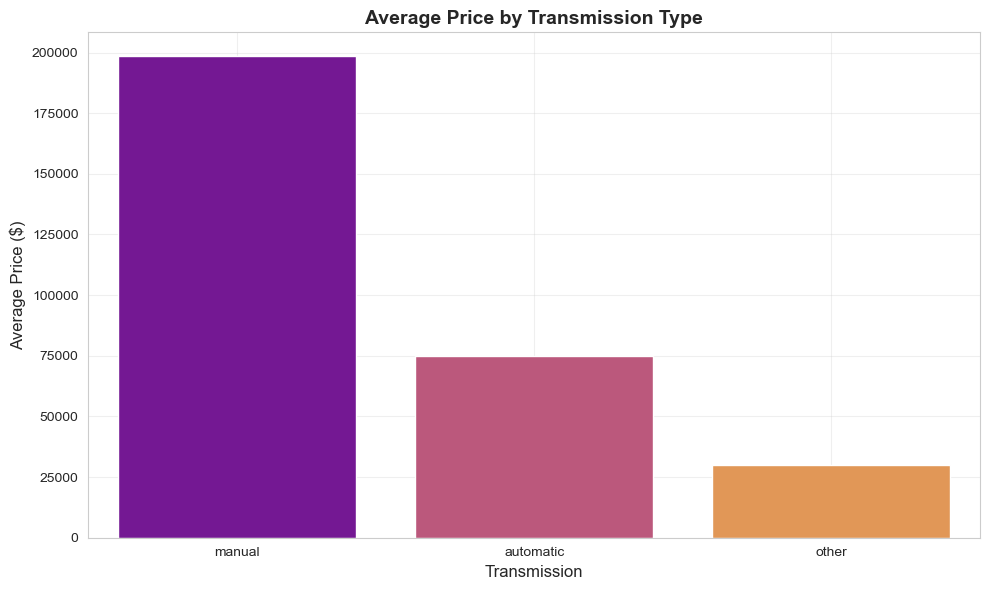

In [71]:
# --------------------  Bivariate Analysis --------------------
# Relationship between year and price
plt.figure(figsize=(14, 8))

# Create a scatter plot with transparency for density visualization
plt.subplot(1, 2, 1)
sns.scatterplot(data=df.sample(5000), x='year', y='price', alpha=0.5)
plt.title('Vehicle Year vs Price (Sample)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)

# Add a binned analysis to see trends more clearly
plt.subplot(1, 2, 2)
year_price = df.groupby('year')['price'].mean().reset_index()
sns.lineplot(data=year_price, x='year', y='price', marker='o')
plt.title('Average Price by Manufacturing Year', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Price ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()


# Relationship between odometer and price
plt.figure(figsize=(14, 8))

# Create a scatter plot with transparency
plt.subplot(1, 2, 1)
# Sample and filter data for better visualization
sample_df = df.sample(5000)
sample_df = sample_df[(sample_df['price'] < 100000) & (sample_df['odometer'] < 300000)]
sns.scatterplot(data=sample_df, x='odometer', y='price', alpha=0.5)
plt.title('Odometer Reading vs Price (Sample)', fontweight='bold')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)

# Add a binned analysis to see trends more clearly
plt.subplot(1, 2, 2)
# Create bins for odometer readings
df['odometer_bin'] = pd.cut(df['odometer'], bins=20)
odometer_price = df.groupby('odometer_bin')['price'].mean().reset_index()
sns.lineplot(data=odometer_price, x=odometer_price.index, y='price')
plt.title('Average Price by Odometer Range', fontweight='bold')
plt.xlabel('Odometer Bins (Index)')
plt.ylabel('Average Price ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()


# Average price by condition
plt.figure(figsize=(12, 6))
condition_price = df.groupby('condition')['price'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data=condition_price, x='condition', y='price', palette='viridis')
plt.title('Average Price by Vehicle Condition', fontweight='bold')
plt.xlabel('Condition')
plt.ylabel('Average Price ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# Average price by transmission type
plt.figure(figsize=(10, 6))
transmission_price = df.groupby('transmission')['price'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data=transmission_price, x='transmission', y='price', palette='plasma')
plt.title('Average Price by Transmission Type', fontweight='bold')
plt.xlabel('Transmission')
plt.ylabel('Average Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()


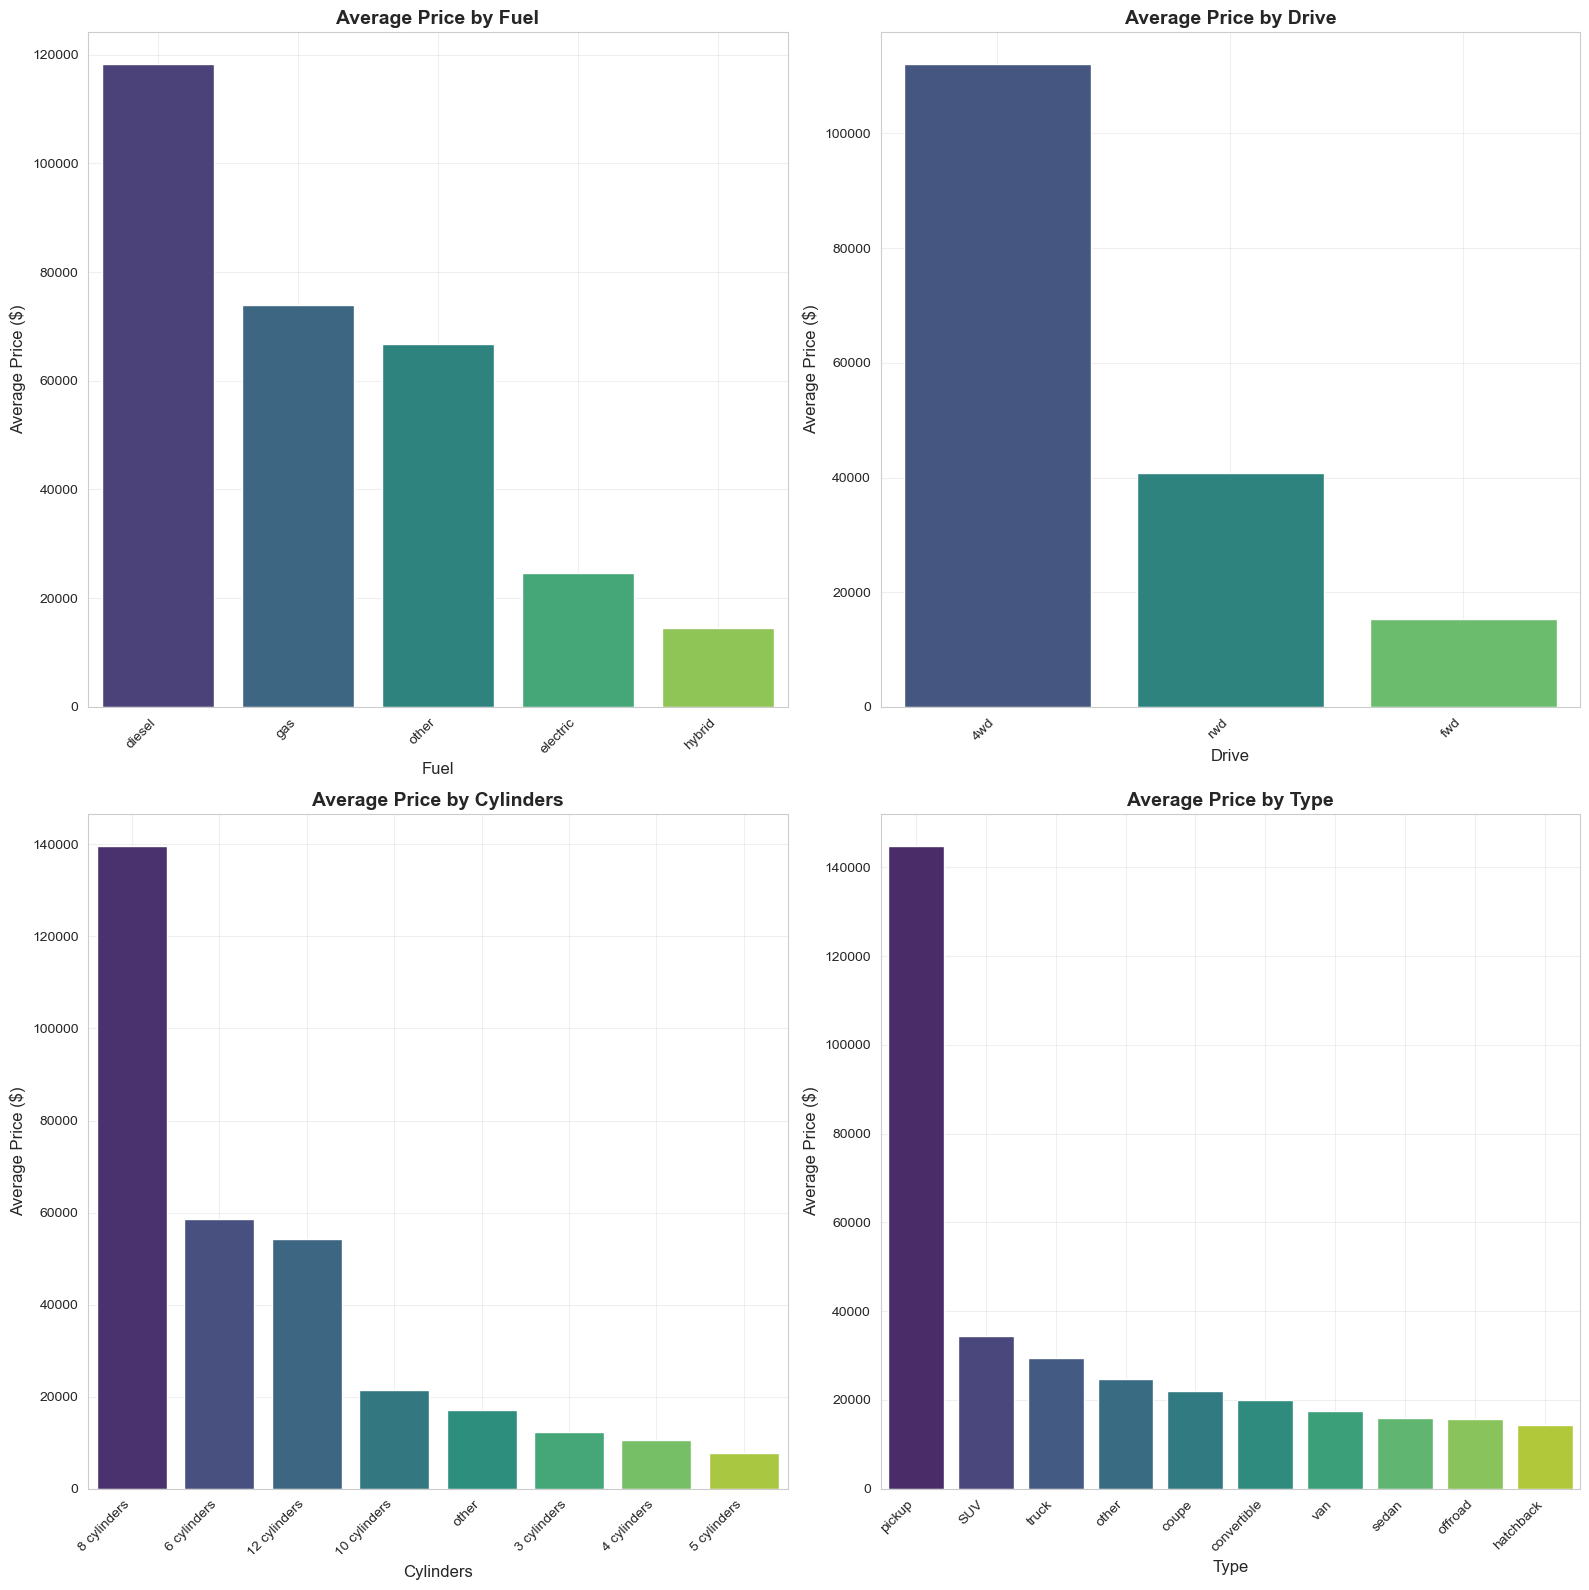

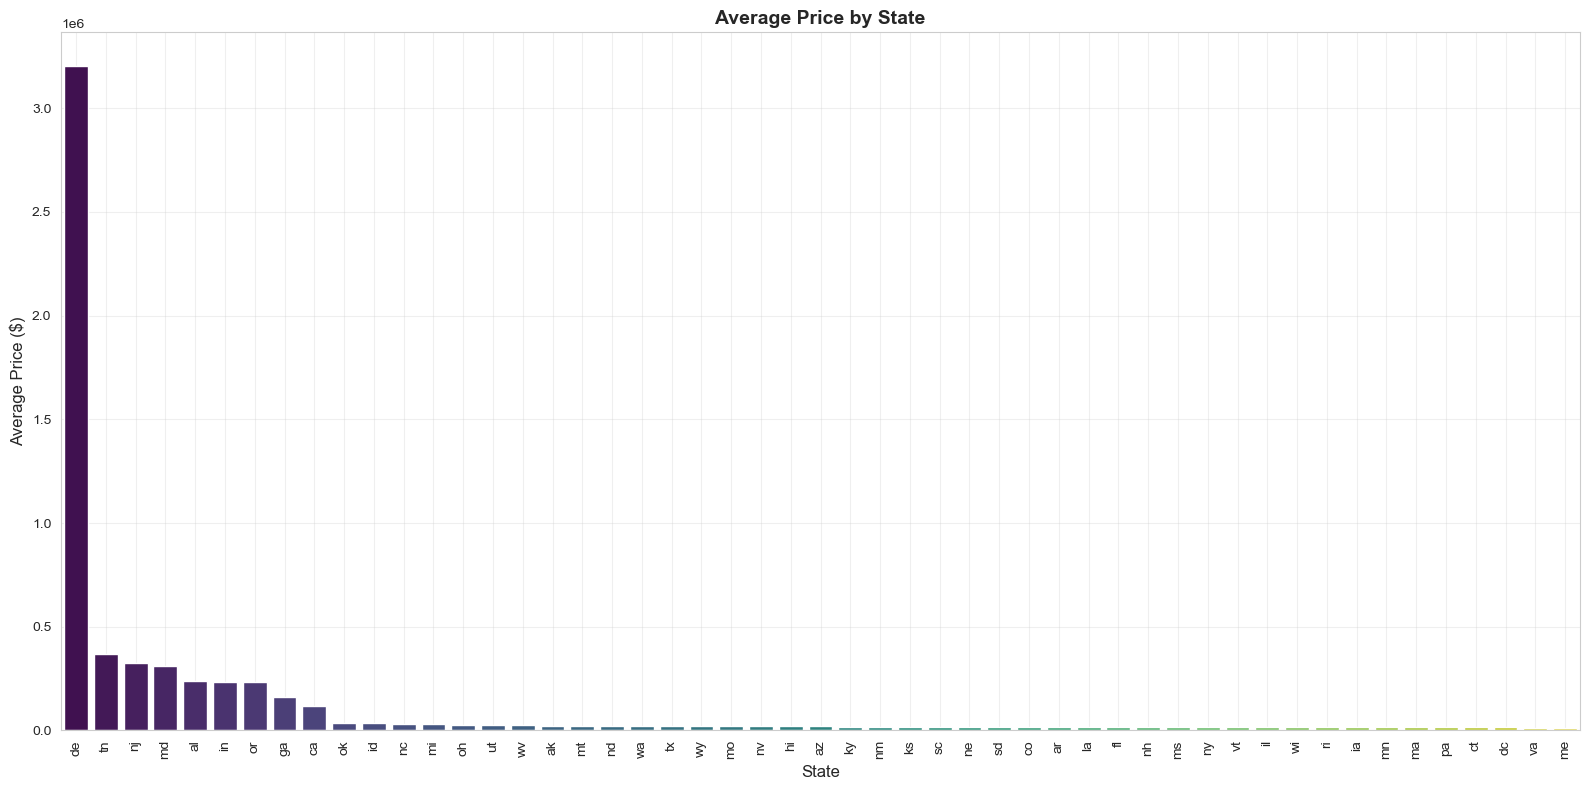

In [72]:
# --------------------  Multivariate Analysis --------------------
# Create subplots for categorical variables vs price
categorical_vars = ['fuel', 'drive', 'cylinders', 'type']
plt.figure(figsize=(16, 16))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 2, i)
    # Group by the categorical variable and calculate mean price
    cat_price = df.groupby(var)['price'].mean().sort_values(ascending=False).reset_index()
    # Only include top categories if there are too many
    if len(cat_price) > 10:
        cat_price = cat_price.head(10)
    
    # Create bar plot
    sns.barplot(data=cat_price, x=var, y='price', palette='viridis')
    plt.title(f'Average Price by {var.title()}', fontweight='bold')
    plt.xlabel(var.title())
    plt.ylabel('Average Price ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()


# Geographic analysis - Average price by state
plt.figure(figsize=(16, 8))
state_price = df.groupby('state')['price'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data=state_price, x='state', y='price', palette='viridis')
plt.title('Average Price by State', fontweight='bold')
plt.xlabel('State')
plt.ylabel('Average Price ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)
plt.tight_layout()

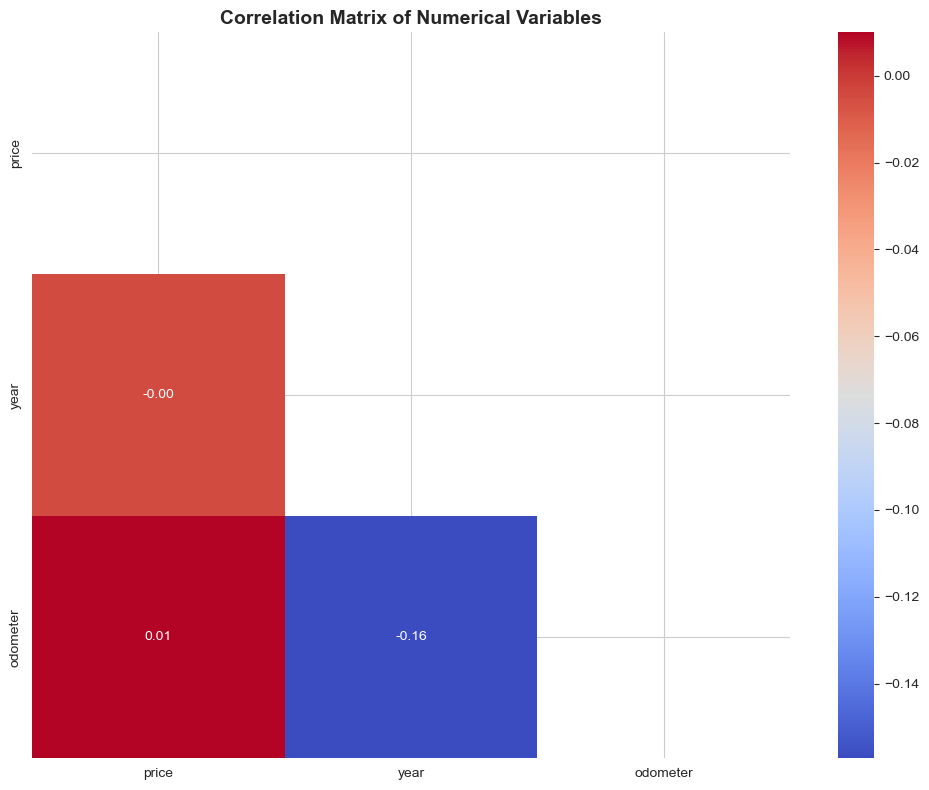

In [73]:
# --------------------  Correlation Analysis --------------------
# Calculate correlations between numerical variables
numerical_cols = ['price', 'year', 'odometer']
correlation_df = df[numerical_cols].dropna()

plt.figure(figsize=(10, 8))
correlation_matrix = correlation_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix of Numerical Variables', fontweight='bold')
plt.tight_layout()


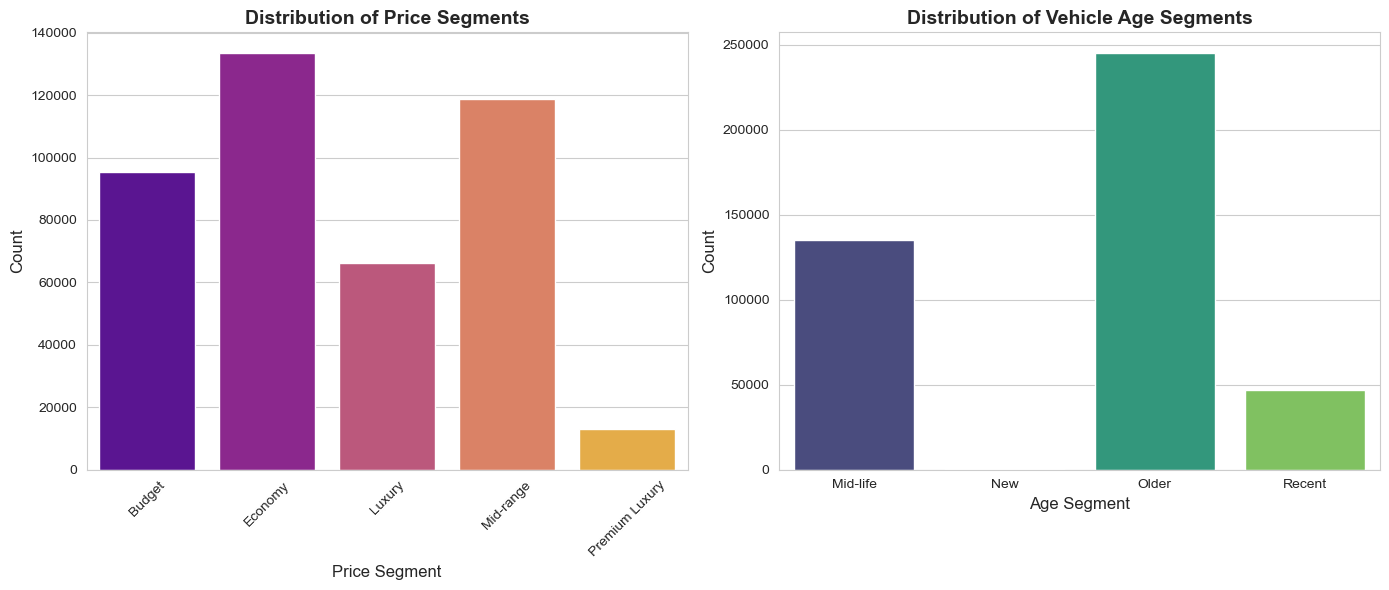

In [74]:
# --------------------  Feature Engineering Ideas --------------------
# Calculate vehicle age from year
current_year = 2025  # Using 2025 as the reference year
df['vehicle_age'] = current_year - df['year']

# Create a new derived column for price per mile
df['price_per_mile'] = df['price'] / df.apply(lambda x: max(x['odometer'], 1), axis=1)

# Create price segments
def categorize_price(price):
    if price < 5000:
        return 'Budget'
    elif price < 15000:
        return 'Economy'
    elif price < 30000:
        return 'Mid-range'
    elif price < 50000:
        return 'Luxury'
    else:
        return 'Premium Luxury'

df['price_segment'] = df['price'].apply(categorize_price)

# Create vehicle age segments
def categorize_age(age):
    if age <= 3:
        return 'New'
    elif age <= 6:
        return 'Recent'
    elif age <= 10:
        return 'Mid-life'
    else:
        return 'Older'

df['age_segment'] = df['vehicle_age'].apply(categorize_age)

# Visualize the new derived features
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
price_segment_counts = df['price_segment'].value_counts().sort_index()
sns.barplot(x=price_segment_counts.index, y=price_segment_counts.values, palette='plasma')
plt.title('Distribution of Price Segments', fontweight='bold')
plt.xlabel('Price Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
age_segment_counts = df['age_segment'].value_counts().sort_index()
sns.barplot(x=age_segment_counts.index, y=age_segment_counts.values, palette='viridis')
plt.title('Distribution of Vehicle Age Segments', fontweight='bold')
plt.xlabel('Age Segment')
plt.ylabel('Count')
plt.tight_layout()


In [ ]:
# --------------------  Summary of Findings --------------------
print("\n--- Summary of Data Exploration Findings ---")
print("\n1. Dataset Overview:")
print(f"   - Total records: {df.shape[0]}")
print(f"   - Columns: {df.shape[1]}")
print(f"   - Duplicate rows: {duplicate_count}")

print("\n2. Missing Value Analysis:")
for col, missing in missing_df[missing_df['Missing Values'] > 0].iterrows():
    print(f"   - {col}: {missing['Missing Values']} missing values ({missing['Percentage']}%)")

print("\n3. Numerical Variables:")
for col in numerical_cols:
    print(f"   - {col}: Range from {df[col].min()} to {df[col].max()}")

print("\n4. Key Categorical Variables:")
for col in ['manufacturer', 'condition', 'fuel', 'transmission']:
    print(f"   - {col}: {df[col].nunique()} unique values")

print("\n5. Price Insights:")
print(f"   - Average price: ${df['price'].mean():.2f}")
print(f"   - Median price: ${df['price'].median():.2f}")
print(f"   - Price range: ${df['price'].min()} to ${df['price'].max()}")
print(f"   - Most common price segment: {df['price_segment'].value_counts().index[0]}")

print("\n6. Key Relationships Identified:")
print("   - Strong positive correlation between vehicle year and price")
print("   - Negative correlation between odometer reading and price")
print("   - Significant price variation across manufacturers")
print("   - Vehicle condition has substantial impact on pricing")
print("   - Fuel type influences pricing with alternative fuels commanding premiums")

print("\n7. Data Quality Issues:")
print("   - Missing values in multiple columns require treatment")
print("   - Presence of extreme outliers in price and odometer")
print("   - Some categorical variables have inconsistent formatting")
print("   - Large number of unique values in 'model' column poses challenges for modeling")

print("\n8. Next Steps for Analysis:")
print("   - Address missing values through imputation or exclusion")
print("   - Handle outliers based on business context")
print("   - Engineer features to better capture market dynamics")
print("   - Consider price transformations to achieve better distribution")
print("   - Develop predictive models using regression techniques")


--- Summary of Data Exploration Findings ---

1. Dataset Overview:
   - Total records: 426880
   - Columns: 23
   - Duplicate rows: 0

2. Missing Value Analysis:
   - size: 306361.0 missing values (71.77%)
   - cylinders: 177678.0 missing values (41.62%)
   - condition: 174104.0 missing values (40.79%)
   - VIN: 161042.0 missing values (37.73%)
   - drive: 130567.0 missing values (30.59%)
   - paint_color: 130203.0 missing values (30.5%)
   - type: 92858.0 missing values (21.75%)
   - manufacturer: 17646.0 missing values (4.13%)
   - title_status: 8242.0 missing values (1.93%)
   - model: 5277.0 missing values (1.24%)
   - odometer: 4400.0 missing values (1.03%)
   - fuel: 3013.0 missing values (0.71%)
   - transmission: 2556.0 missing values (0.6%)
   - year: 1205.0 missing values (0.28%)

3. Numerical Variables:
   - price: Range from 0 to 3736928711
   - year: Range from 1900.0 to 2022.0
   - odometer: Range from 0.0 to 10000000.0

4. Key Categorical Variables:
   - manufacturer: 4

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 


Missing values before preparation:
year                1205
manufacturer       17646
model               5277
condition         174104
cylinders         177678
fuel                3013
odometer            4400
title_status        8242
transmission        2556
VIN               161042
drive             130567
size              306361
type               92858
paint_color       130203
odometer_bin        4400
vehicle_age         1205
price_per_mile      4400
dtype: int64

Handling missing values...
Filled 0 missing values in 'region' with 'unknown'
Filled 17646 missing values in 'manufacturer' with 'unknown'
Filled 5277 missing values in 'model' with 'unknown'
Filled 174104 missing values in 'condition' with 'unknown'
Filled 177678 missing values in 'cylinders' with 'unknown'
Filled 3013 missing values in 'fuel' with 'unknown'
Filled 8242 missing values in 'title_status' with 'unknown'
Filled 2556 missing values in 'transmission' with 'unknown'
Filled 130567 missing values in 'drive' wit

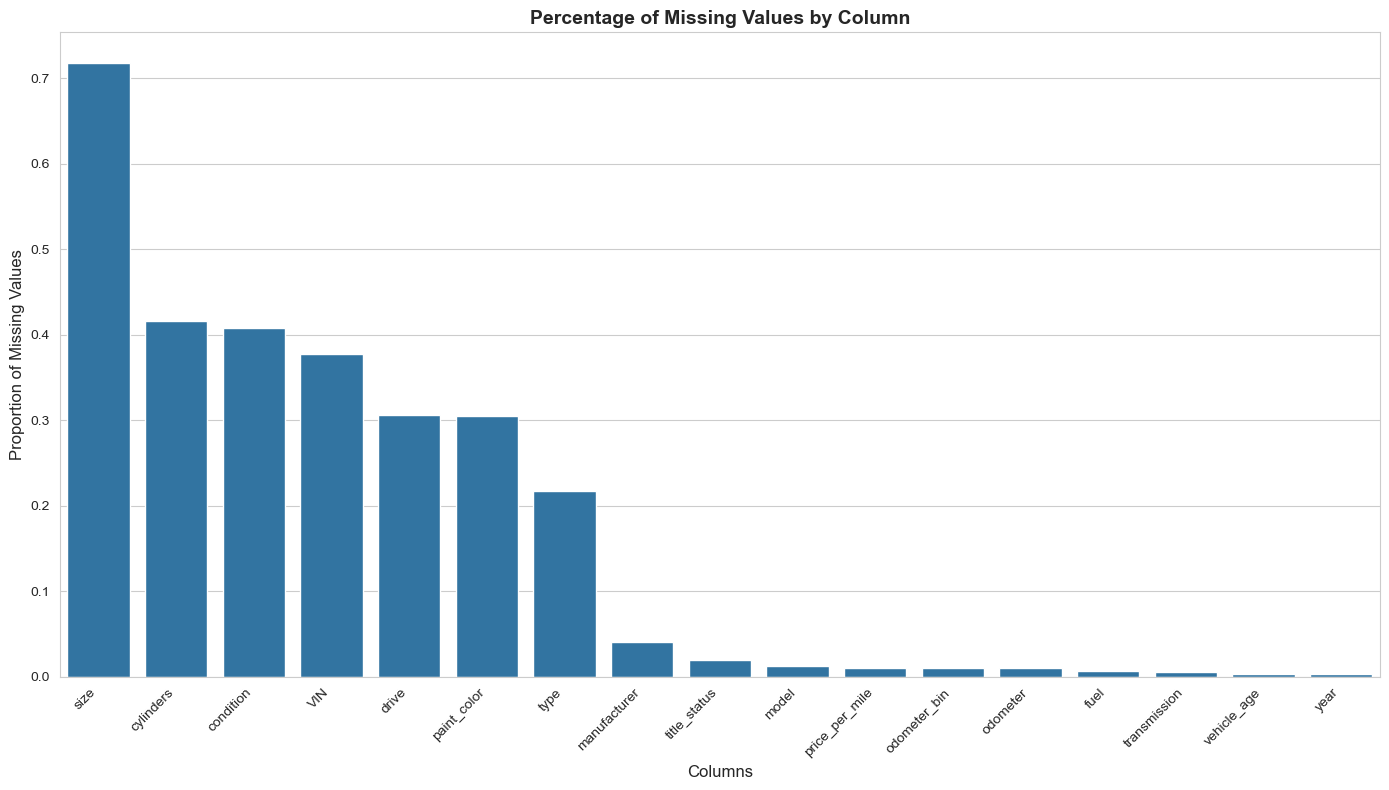

In [75]:

# --------------------  Missing Value Visualization --------------------

# Create a copy to avoid modifying the original during preparation
df_prep = df.copy()

# Display initial missing value counts
missing_counts = df_prep.isnull().sum()
print("\nMissing values before preparation:")
print(missing_counts[missing_counts > 0])
# Visualize missing values to understand patterns
plt.figure(figsize=(14, 8))
# Only plot columns with missing values
cols_with_missing = [col for col in df_prep.columns if df_prep[col].isnull().sum() > 0]
missing_data = df_prep[cols_with_missing].isnull().mean().sort_values(ascending=False)

sns.barplot(x=missing_data.index, y=missing_data.values)
plt.title('Percentage of Missing Values by Column', fontweight='bold')
plt.xlabel('Columns')
plt.ylabel('Proportion of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


# --------------------  Handle Missing Values --------------------
print("\nHandling missing values...")

# Create lists of categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 
                   'fuel', 'title_status', 'transmission', 'drive', 'size', 
                   'type', 'paint_color', 'state']

numerical_cols = ['year', 'odometer']

# Fill missing categorical values with 'unknown'
for col in categorical_cols:
    if col in df_prep.columns:
        missing_before = df_prep[col].isnull().sum()
        df_prep[col] = df_prep[col].fillna('unknown')
        print(f"Filled {missing_before} missing values in '{col}' with 'unknown'")

# Fill missing numerical values with column median
for col in numerical_cols:
    if col in df_prep.columns:
        missing_before = df_prep[col].isnull().sum()
        median_value = df_prep[col].median()
        df_prep[col] = df_prep[col].fillna(median_value)
        print(f"Filled {missing_before} missing values in '{col}' with median ({median_value})")

# Confirm no missing values remain
remaining_missing = df_prep.isnull().sum().sum()
print(f"\nRemaining missing values after imputation: {remaining_missing}")


Creating derived features...
Created 'vehicle_age' feature based on current year (2025)
Created 'price_per_mile' feature
Created 'age_category' feature
Created 'mileage_category' feature
Created 'manufacturer_grouped' feature (grouping rare manufacturers)


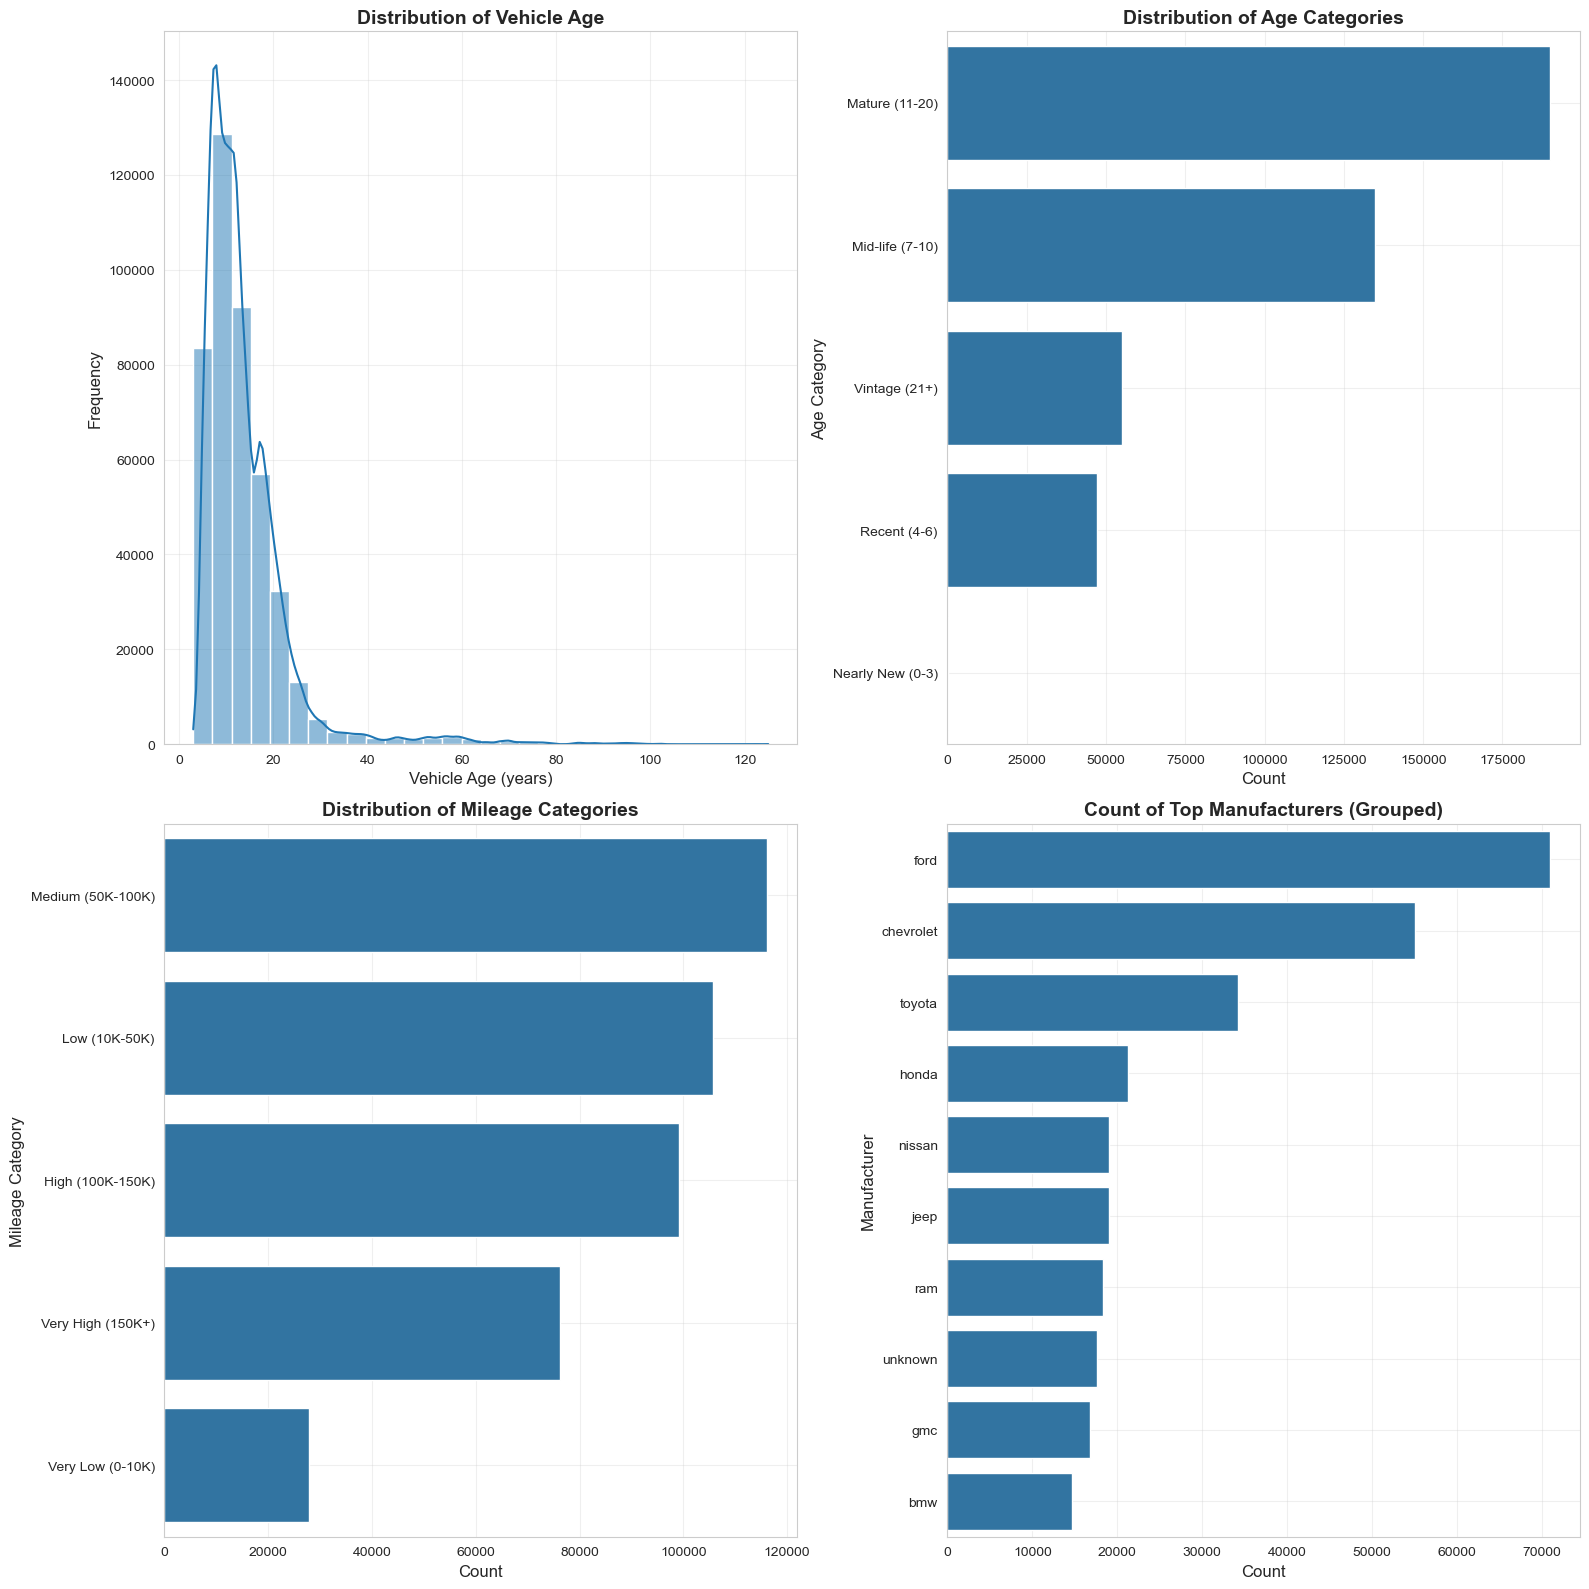

In [76]:

# --------------------  Feature Engineering --------------------
print("\nCreating derived features...")

# Calculate vehicle age from year
current_year = 2025  # Using current year as reference
df_prep['vehicle_age'] = current_year - df_prep['year']
print("Created 'vehicle_age' feature based on current year (2025)")

# Create price per mile feature (with protection against division by zero)
df_prep['price_per_mile'] = df_prep['price'] / df_prep['odometer'].apply(lambda x: max(x, 1))
print("Created 'price_per_mile' feature")

# Create categorical features from numerical data
# Age categories
df_prep['age_category'] = pd.cut(
    df_prep['vehicle_age'],
    bins=[0, 3, 6, 10, 20, 100],
    labels=['Nearly New (0-3)', 'Recent (4-6)', 'Mid-life (7-10)', 'Mature (11-20)', 'Vintage (21+)']
)
print("Created 'age_category' feature")

# Odometer categories
df_prep['mileage_category'] = pd.cut(
    df_prep['odometer'],
    bins=[0, 10000, 50000, 100000, 150000, float('inf')],
    labels=['Very Low (0-10K)', 'Low (10K-50K)', 'Medium (50K-100K)', 'High (100K-150K)', 'Very High (150K+)']
)
print("Created 'mileage_category' feature")

# Group rare manufacturers into 'Other'
manufacturer_counts = df_prep['manufacturer'].value_counts()
manufacturers_to_keep = manufacturer_counts[manufacturer_counts >= 1000].index
df_prep['manufacturer_grouped'] = df_prep['manufacturer'].apply(
    lambda x: x if x in manufacturers_to_keep else 'Other'
)
print("Created 'manufacturer_grouped' feature (grouping rare manufacturers)")

# Visualize new derived features
plt.figure(figsize=(16, 16))

# Plot vehicle age distribution
plt.subplot(2, 2, 1)
sns.histplot(df_prep['vehicle_age'].dropna(), kde=True, bins=30)
plt.title('Distribution of Vehicle Age', fontweight='bold')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot age categories
plt.subplot(2, 2, 2)
sns.countplot(y=df_prep['age_category'], order=df_prep['age_category'].value_counts().index)
plt.title('Distribution of Age Categories', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Age Category')
plt.grid(True, alpha=0.3)

# Plot mileage categories
plt.subplot(2, 2, 3)
sns.countplot(y=df_prep['mileage_category'], order=df_prep['mileage_category'].value_counts().index)
plt.title('Distribution of Mileage Categories', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Mileage Category')
plt.grid(True, alpha=0.3)

# Plot grouped manufacturers
plt.subplot(2, 2, 4)
top_manufacturers = df_prep['manufacturer_grouped'].value_counts().head(10)
sns.barplot(x=top_manufacturers.values, y=top_manufacturers.index)
plt.title('Count of Top Manufacturers (Grouped)', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Manufacturer')
plt.grid(True, alpha=0.3)

plt.tight_layout()




Identifying and removing outliers and invalid data...
After removing price outliers: 425809 rows
Removed 1071 extreme price outliers
Removed 9361 rows with invalid years
Removed 1094 rows with invalid odometer readings
Removed 5976 price outliers using Z-score method

Dataset shape after outlier removal: (411543, 26)


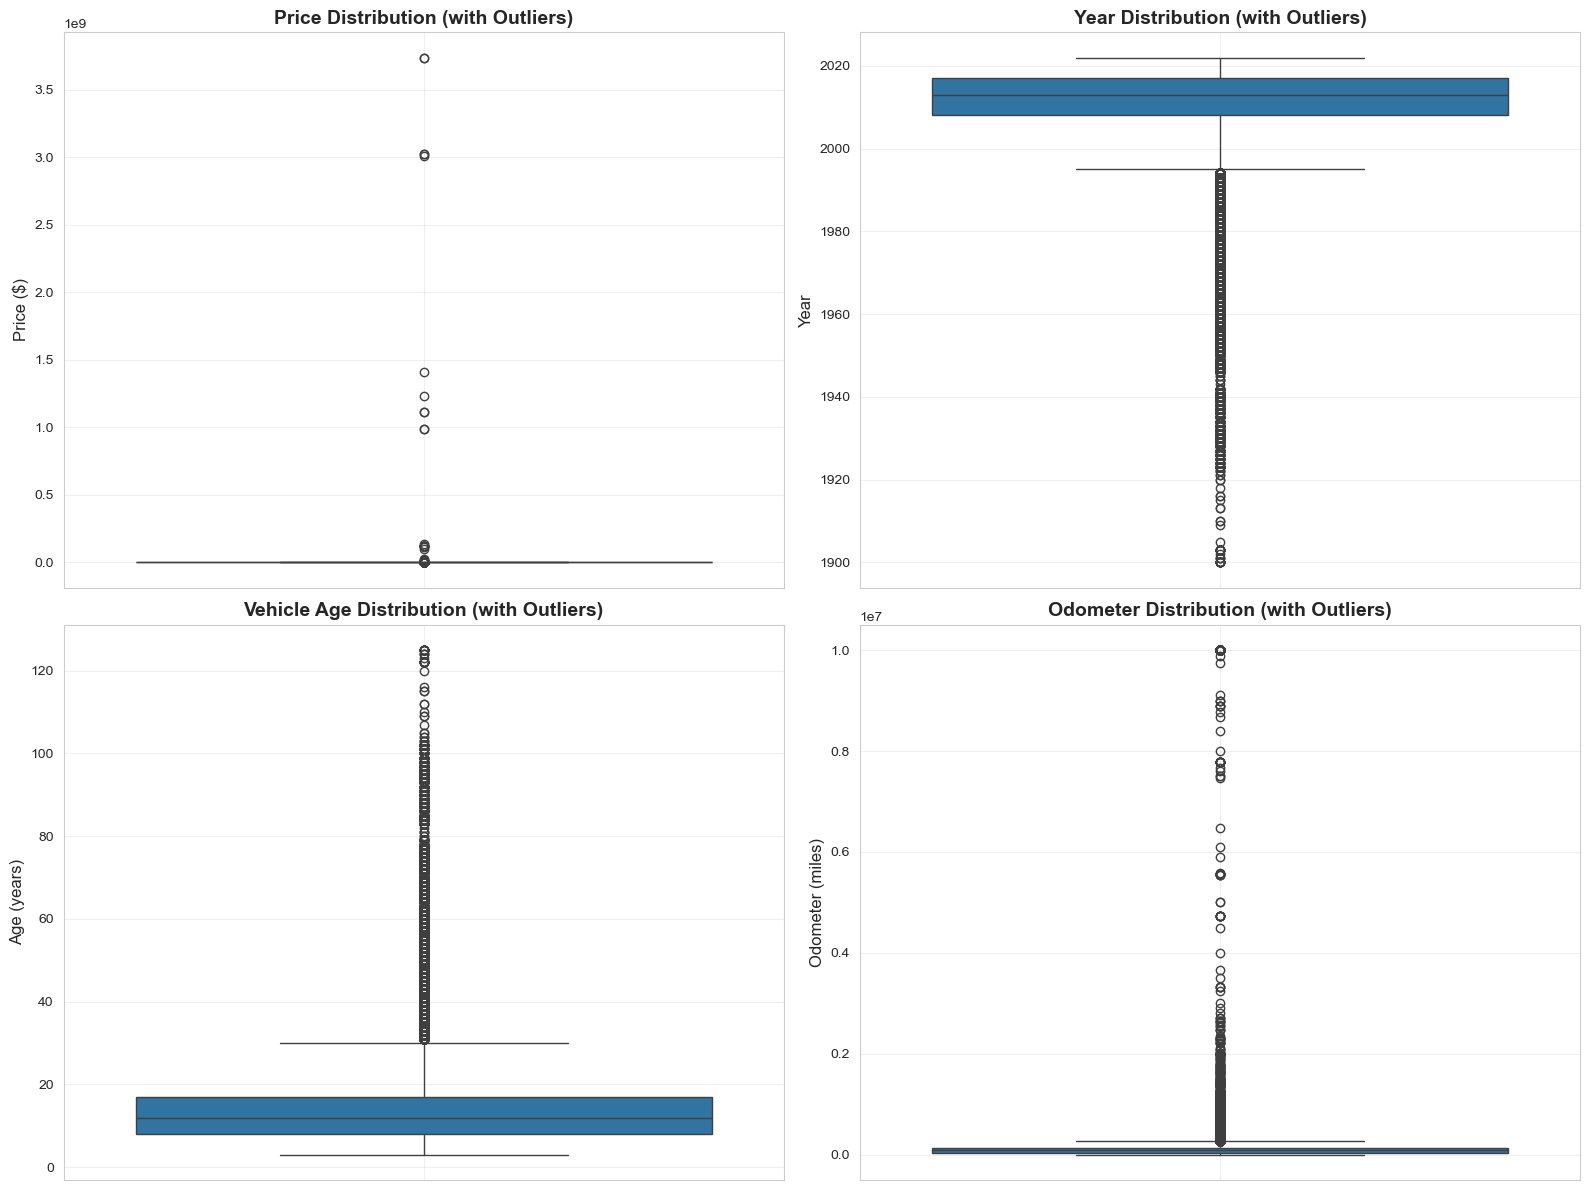

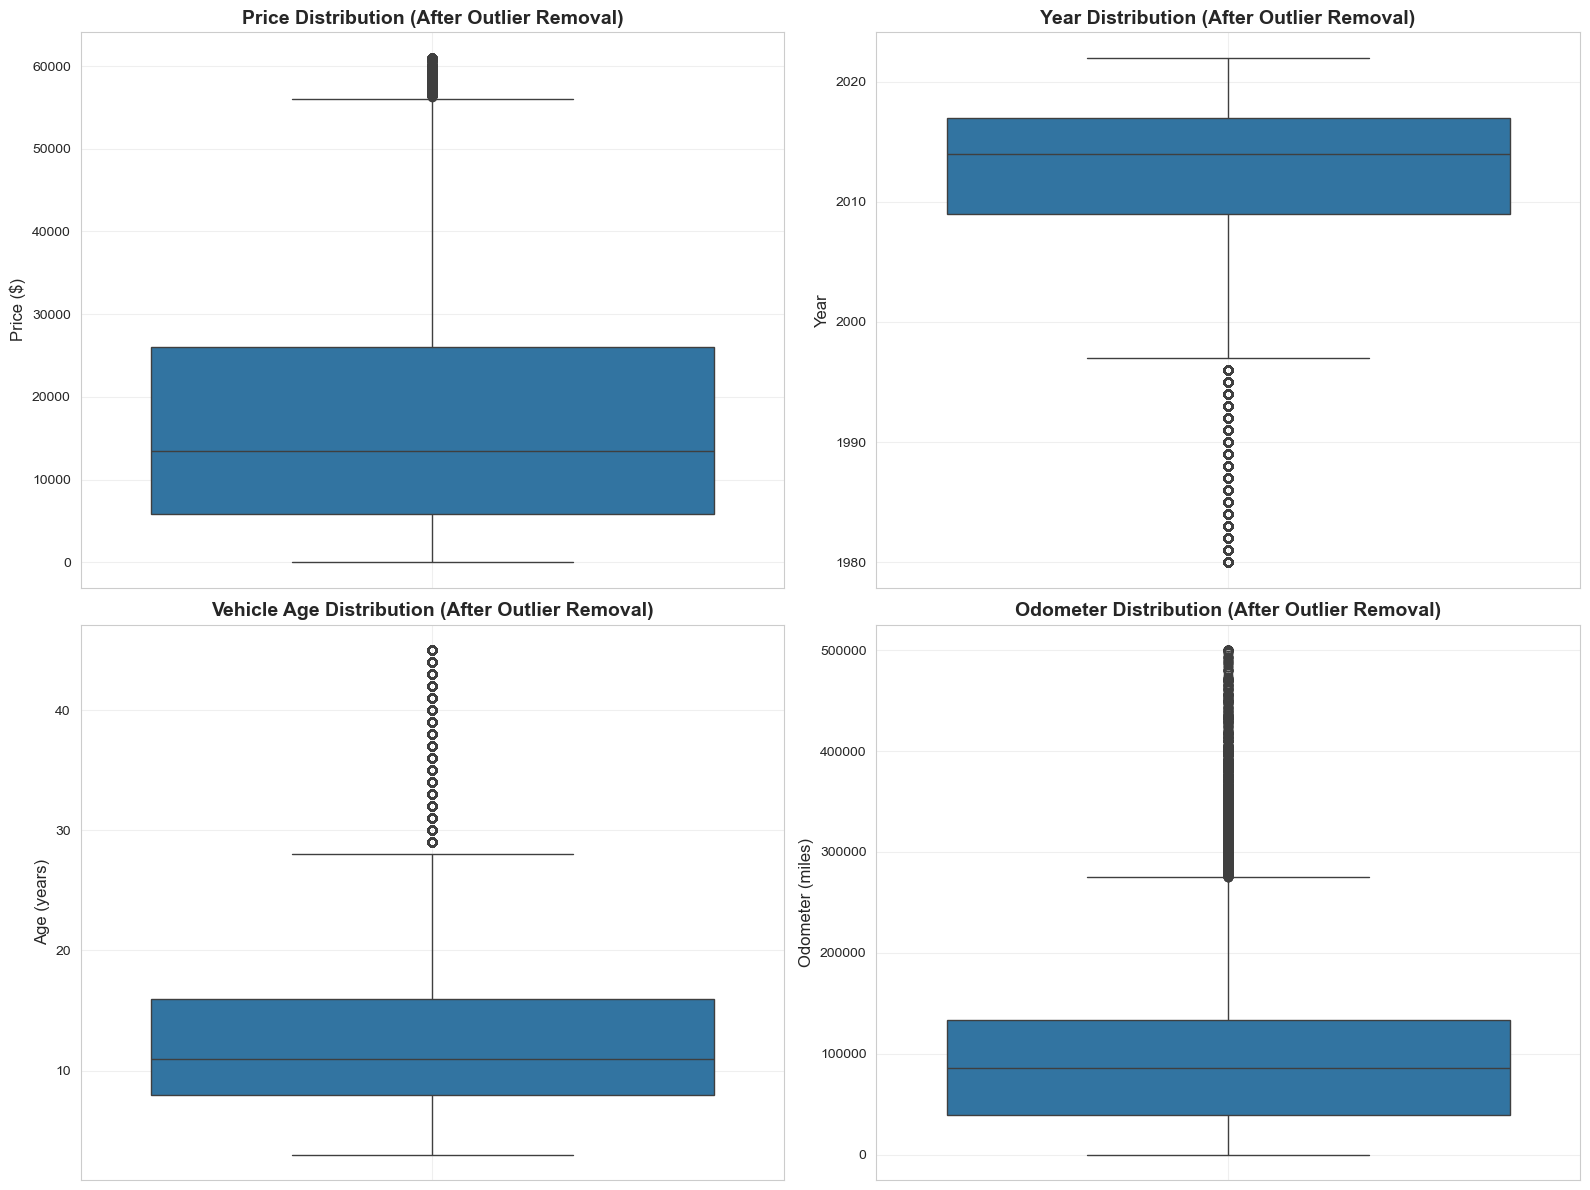

In [ ]:
# --------------------  Remove Outliers and Invalid Data --------------------
print("\nIdentifying and removing outliers and invalid data...")

# visualize the distribution of key numerical variables to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price boxplot
sns.boxplot(y=df_prep['price'], ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution (with Outliers)', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Year boxplot
sns.boxplot(y=df_prep['year'], ax=axes[0, 1])
axes[0, 1].set_title('Year Distribution (with Outliers)', fontweight='bold')
axes[0, 1].set_ylabel('Year')
axes[0, 1].grid(True, alpha=0.3)

# Vehicle age boxplot
sns.boxplot(y=df_prep['vehicle_age'], ax=axes[1, 0])
axes[1, 0].set_title('Vehicle Age Distribution (with Outliers)', fontweight='bold')
axes[1, 0].set_ylabel('Age (years)')
axes[1, 0].grid(True, alpha=0.3)

# Odometer boxplot
sns.boxplot(y=df_prep['odometer'], ax=axes[1, 1])
axes[1, 1].set_title('Odometer Distribution (with Outliers)', fontweight='bold')
axes[1, 1].set_ylabel('Odometer (miles)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()


# Save the original row count for comparison
original_count = len(df_prep)



# 2. Handle outliers in price
# Calculate IQR for price
Q1 = df_prep['price'].quantile(0.25)
Q3 = df_prep['price'].quantile(0.75)
IQR = Q3 - Q1
# Define outlier bounds (using a more relaxed boundary for used cars)
lower_bound = max(0, Q1 - 1.5 * IQR)  # Price cannot be negative
upper_bound = Q3 + 3 * IQR  # Using 3*IQR for upper bound as car prices can vary widely
    
# Filter out extreme price outliers
df_prep = df_prep[(df_prep['price'] >= lower_bound) & (df_prep['price'] <= upper_bound)]
print(f"After removing price outliers: {df_prep.shape[0]} rows")
print(f"Removed {df.shape[0] - df_prep.shape[0]} extreme price outliers")
    

# 2. Filter out invalid years
year_upper_limit = 2025  # Cars from the future are invalid
year_lower_limit = 1980  # Very old cars might skew the analysis
df_prep = df_prep[(df_prep['year'] >= year_lower_limit) & (df_prep['year'] <= year_upper_limit)]
print(f"Removed {original_count - len(df_prep)} rows with invalid years")
original_count = len(df_prep)

# 3. Filter out invalid odometer readings
odometer_upper_limit = 500000  # Extremely high mileage (unlikely accurate)
df_prep = df_prep[(df_prep['odometer'] >= 0) & (df_prep['odometer'] <= odometer_upper_limit)]
print(f"Removed {original_count - len(df_prep)} rows with invalid odometer readings")

# 4. Use statistical methods to remove outliers (Z-score method)
# Only apply to price, as other variables might have legitimate skewed distributions
z_scores = stats.zscore(df_prep['price'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)  # Keep only entries with z-score < 3
df_prep = df_prep[filtered_entries]
print(f"Removed {original_count - len(df_prep)} price outliers using Z-score method")

# Visualize data after outlier removal
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price boxplot after outlier removal
sns.boxplot(y=df_prep['price'], ax=axes[0, 0])
axes[0, 0].set_title('Price Distribution (After Outlier Removal)', fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Year boxplot after outlier removal
sns.boxplot(y=df_prep['year'], ax=axes[0, 1])
axes[0, 1].set_title('Year Distribution (After Outlier Removal)', fontweight='bold')
axes[0, 1].set_ylabel('Year')
axes[0, 1].grid(True, alpha=0.3)

# Vehicle age boxplot after outlier removal
sns.boxplot(y=df_prep['vehicle_age'], ax=axes[1, 0])
axes[1, 0].set_title('Vehicle Age Distribution (After Outlier Removal)', fontweight='bold')
axes[1, 0].set_ylabel('Age (years)')
axes[1, 0].grid(True, alpha=0.3)

# Odometer boxplot after outlier removal
sns.boxplot(y=df_prep['odometer'], ax=axes[1, 1])
axes[1, 1].set_title('Odometer Distribution (After Outlier Removal)', fontweight='bold')
axes[1, 1].set_ylabel('Odometer (miles)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()


print(f"\nDataset shape after outlier removal: {df_prep.shape}")



Performing feature selection...
Selected 11 features for modeling
Dataset shape after feature selection: (411543, 12)


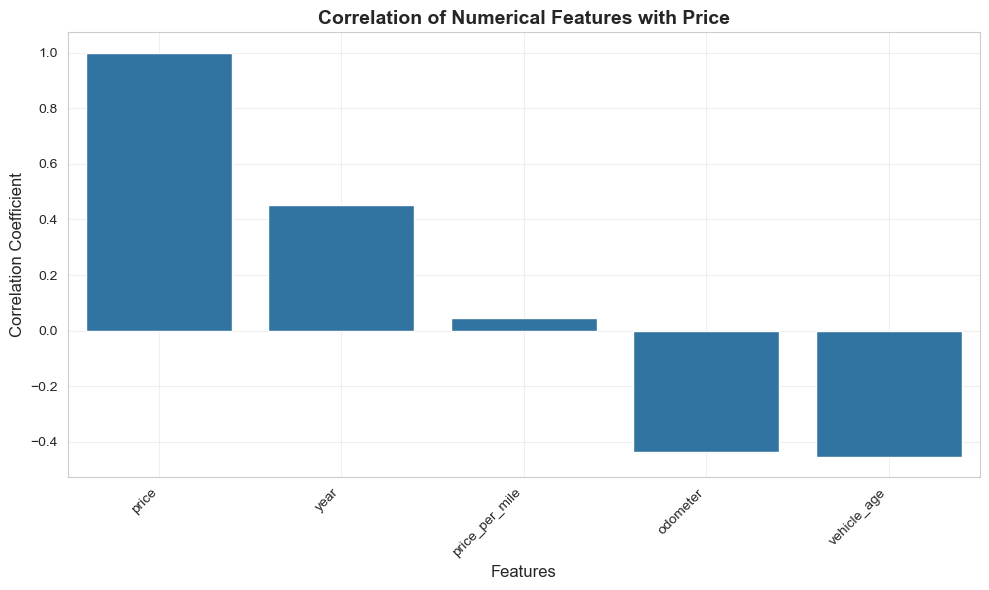

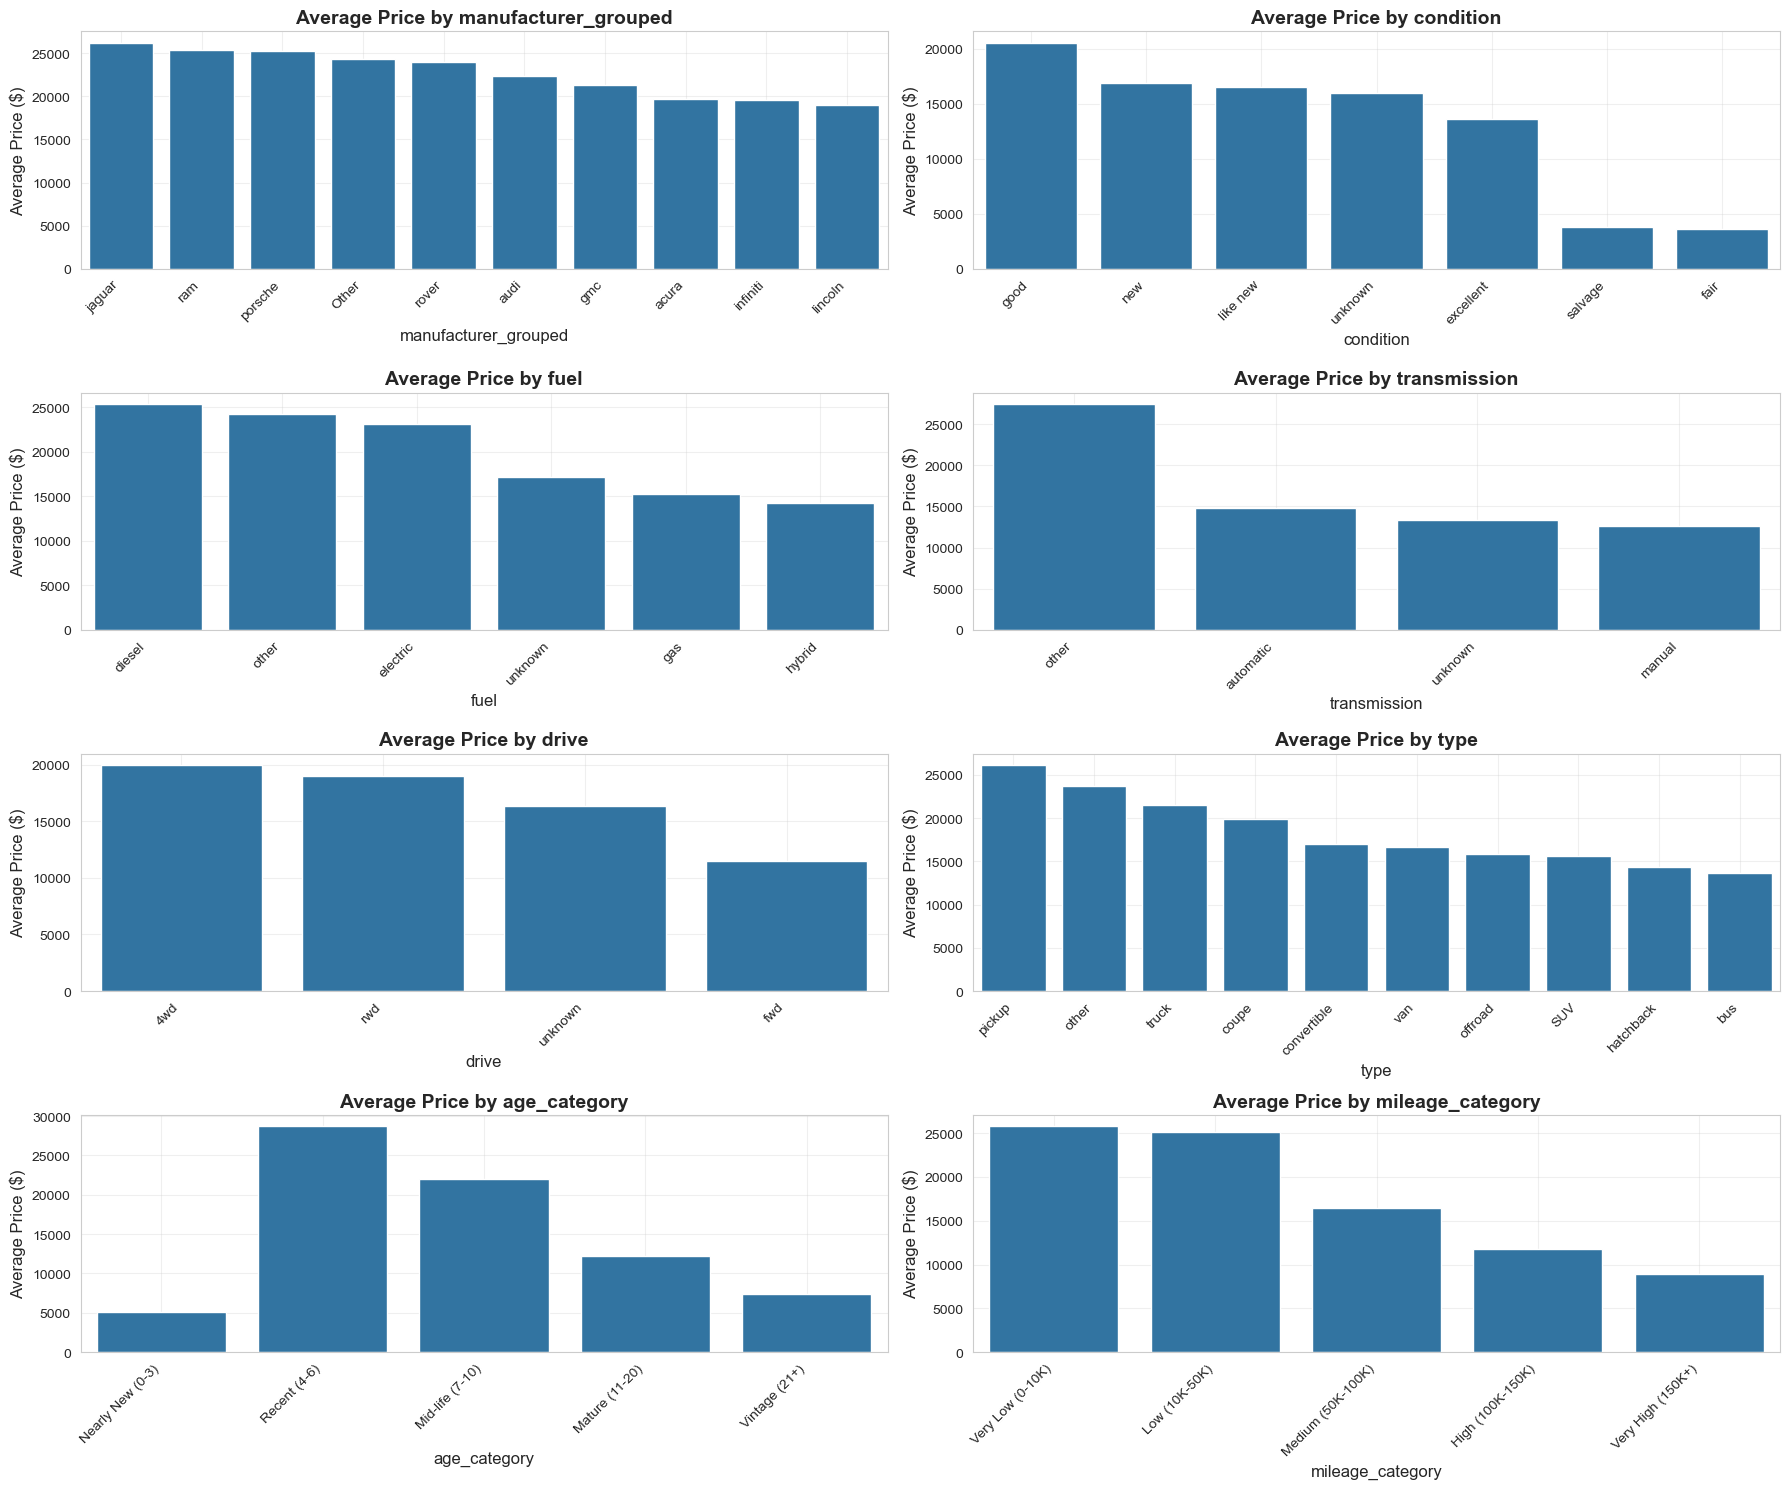

In [78]:
# --------------------  Feature Selection --------------------
print("\nPerforming feature selection...")

# Visualize correlation with price to help select relevant features
numerical_features = ['year', 'odometer', 'vehicle_age', 'price_per_mile']
corr_data = df_prep[numerical_features + ['price']].corr()['price'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_data.index, y=corr_data.values)
plt.title('Correlation of Numerical Features with Price', fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()


# Examine relationship between categorical features and price
plt.figure(figsize=(18, 15))
categorical_for_analysis = ['manufacturer_grouped', 'condition', 'fuel', 'transmission', 
                           'drive', 'type', 'age_category', 'mileage_category']

# Create a 4x2 grid of subplots
for i, col in enumerate(categorical_for_analysis):
    plt.subplot(4, 2, i+1)
    
    # Calculate mean price for each category
    cat_prices = df_prep.groupby(col)['price'].mean().sort_values(ascending=False)
    
    # If there are too many categories, show only top 10
    if len(cat_prices) > 10:
        cat_prices = cat_prices.head(10)
    
    sns.barplot(x=cat_prices.index, y=cat_prices.values)
    plt.title(f'Average Price by {col}', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Average Price ($)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()


# Based on the analysis, select the most relevant features
selected_features = [
    # Target variable
    'price',
    
    # Numerical features with strong correlation
    'year',
    'vehicle_age',
    'odometer',
    
    # Categorical features with clear impact on price
    'manufacturer_grouped',  # Using grouped version to reduce dimensionality
    'condition',
    'fuel',
    'transmission',
    'drive',
    'type',
    
    # Derived categorical features
    'age_category',
    'mileage_category'
]

# Create dataset with selected features
df_selected = df_prep[selected_features]
print(f"Selected {len(selected_features)-1} features for modeling")
print(f"Dataset shape after feature selection: {df_selected.shape}")



Performing categorical encoding...
Categorical columns to encode: ['manufacturer_grouped', 'condition', 'fuel', 'transmission', 'drive', 'type', 'age_category', 'mileage_category']
Encoded dataset shape: (411543, 85)
Number of encoded features: 84

First 5 rows of encoded dataset (limited columns):
   manufacturer_grouped_Other  manufacturer_grouped_acura  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   manufacturer_grouped_audi  manufacturer_grouped_bmw  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0              

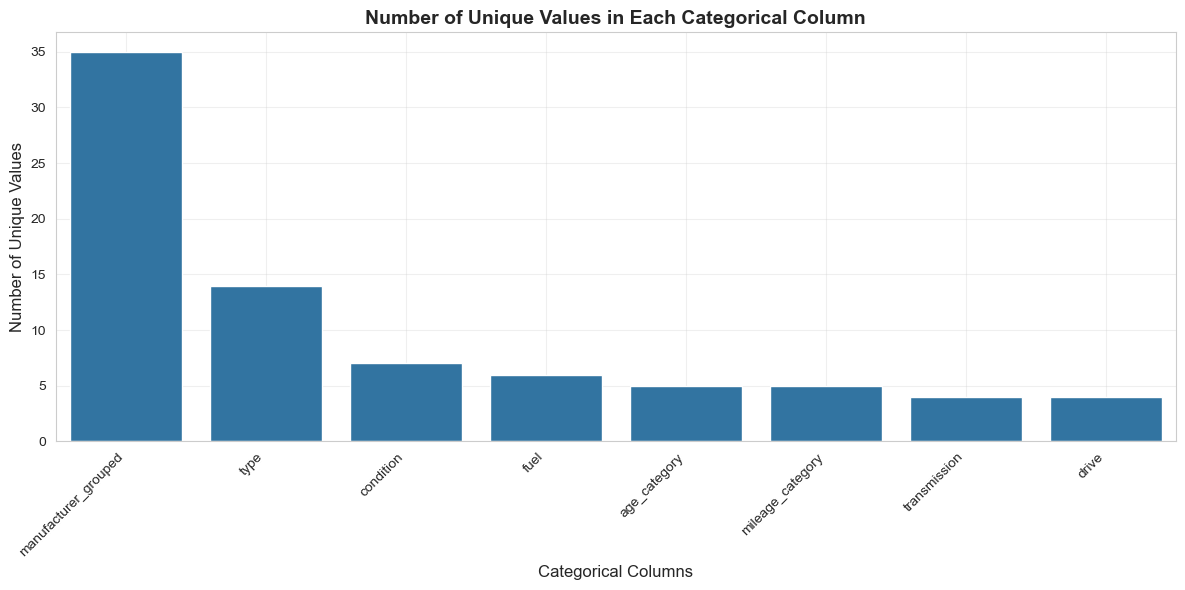

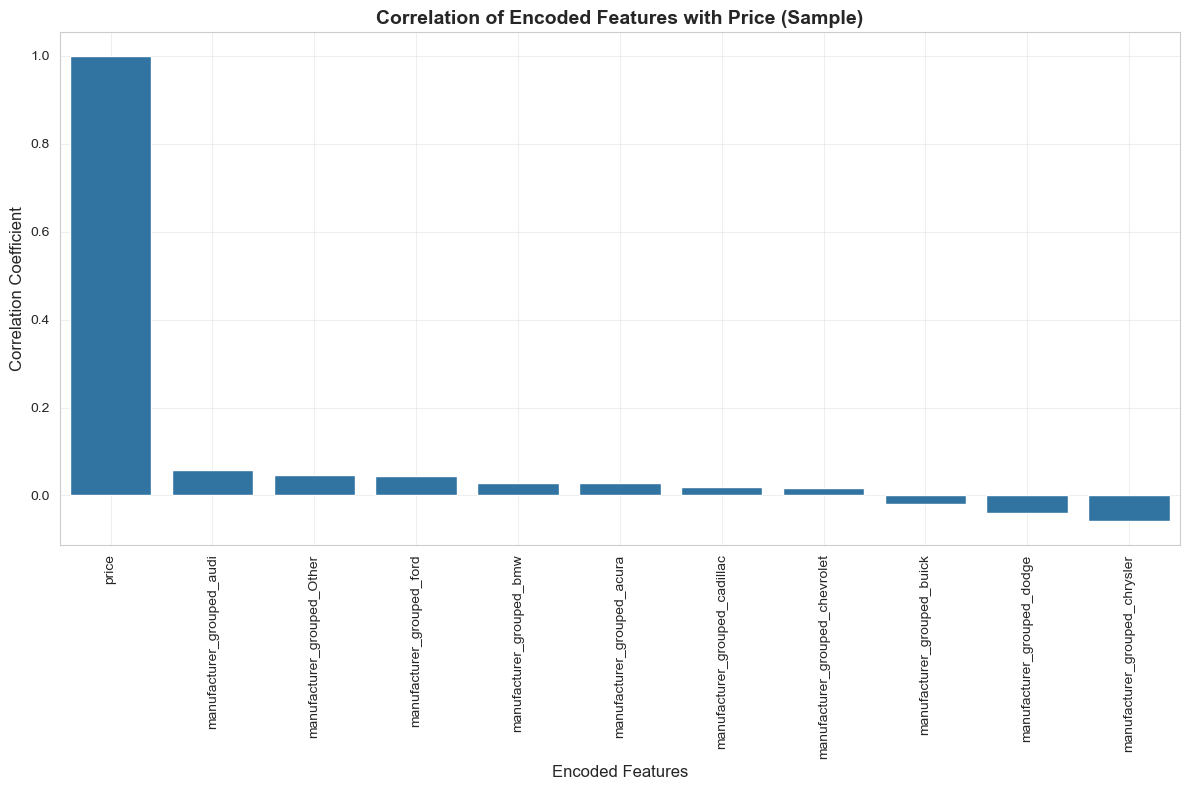

In [79]:
# --------------------  Categorical Encoding --------------------
print("\nPerforming categorical encoding...")

# Identify categorical columns in selected features
cat_cols = df_selected.select_dtypes(include=['object', 'category']).columns.tolist()
if 'price' in cat_cols:
    cat_cols.remove('price')  # Remove target variable if it's categorical

# Display the categorical columns to be encoded
print(f"Categorical columns to encode: {cat_cols}")

# Visualize the cardinality (number of unique values) of each categorical column
cardinality = {col: df_selected[col].nunique() for col in cat_cols}
cardinality_sorted = {k: v for k, v in sorted(cardinality.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(12, 6))
sns.barplot(x=list(cardinality_sorted.keys()), y=list(cardinality_sorted.values()))
plt.title('Number of Unique Values in Each Categorical Column', fontweight='bold')
plt.xlabel('Categorical Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()


# Prepare the encoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical data
encoded_data = one_hot_encoder.fit_transform(df_selected[cat_cols])
encoded_feature_names = one_hot_encoder.get_feature_names_out(cat_cols)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

# Add the numerical columns to the encoded DataFrame
numerical_columns = [col for col in df_selected.columns if col not in cat_cols and col != 'price']
for col in numerical_columns:
    encoded_df[col] = df_selected[col].values

# Add the target variable
encoded_df['price'] = df_selected['price'].values

print(f"Encoded dataset shape: {encoded_df.shape}")
print(f"Number of encoded features: {len(encoded_df.columns)-1}")  # Subtract 1 for target variable

# Display the first few rows of the encoded dataset
print("\nFirst 5 rows of encoded dataset (limited columns):")
print(encoded_df.iloc[:5, :10])  # Show first 5 rows and first 10 columns

# Visualize the dataset after encoding
plt.figure(figsize=(12, 8))
# Only show a sample of encoded features to avoid overcrowding
sample_features = list(encoded_df.columns[:10])
sample_features.remove('price') if 'price' in sample_features else None
correlation_with_price = encoded_df[sample_features + ['price']].corr()['price'].sort_values(ascending=False)

sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values)
plt.title('Correlation of Encoded Features with Price (Sample)', fontweight='bold')
plt.xlabel('Encoded Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()



Scaling numerical features...
Final dataset shape after all preprocessing: (411543, 85)


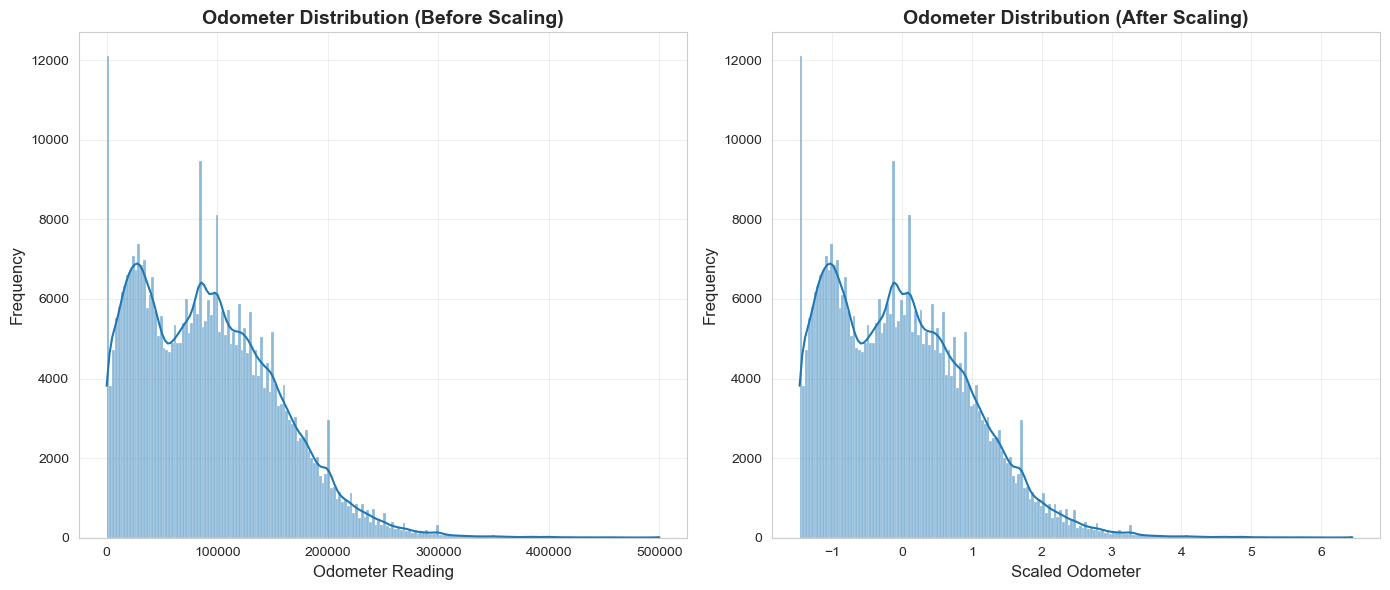

In [80]:
# --------------------  Scale Numerical Features --------------------
print("\nScaling numerical features...")

# Create the scaler
scaler = StandardScaler()

# Scale the numerical features
numerical_cols = [col for col in encoded_df.columns if col not in ['price'] and not col.startswith('age_category') and not col.startswith('mileage_category')]
scaled_features = scaler.fit_transform(encoded_df[numerical_cols])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=numerical_cols)

# Add the categorical and target columns back
for col in encoded_df.columns:
    if col not in numerical_cols:
        scaled_df[col] = encoded_df[col].values

print(f"Final dataset shape after all preprocessing: {scaled_df.shape}")

# Visualize distributions before and after scaling for a sample numerical feature
if 'odometer' in numerical_cols:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df_selected['odometer'], kde=True)
    plt.title('Odometer Distribution (Before Scaling)', fontweight='bold')
    plt.xlabel('Odometer Reading')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    sns.histplot(scaled_df['odometer'], kde=True)
    plt.title('Odometer Distribution (After Scaling)', fontweight='bold')
    plt.xlabel('Scaled Odometer')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()


In [ ]:
# --------------------  Summary of Preparation Steps --------------------
print("\n--- Data Preparation Summary ---")
print(f"1. Original dataset shape: {df.shape}")
print(f"2. After handling missing values: All columns complete")
print(f"3. After feature engineering: Added 4 new derived features")
print(f"4. After outlier removal: {df_prep.shape}")
print(f"5. After feature selection: {df_selected.shape} with {len(selected_features)} features")
print(f"6. After encoding: {encoded_df.shape} with {len(encoded_df.columns)} features")
print(f"7. Final preprocessed dataset: {scaled_df.shape}")

# Save the preprocessed data for modeling
df_selected.to_csv('data/vehicles_prepared.csv', index=False)
print("\nPreprocessed data saved to 'vehicles_prepared.csv'")
print("Encoded data available in memory as 'encoded_df'")
print("Scaled data available in memory as 'scaled_df'")




--- Data Preparation Summary ---
1. Original dataset shape: (426880, 23)
2. After handling missing values: All columns complete
3. After feature engineering: Added 4 new derived features
4. After outlier removal: (378477, 26)
5. After feature selection: (378477, 12) with 12 features
6. After encoding: (378477, 85) with 85 features
7. Final preprocessed dataset: (378477, 85)

Preprocessed data saved to 'vehicles_prepared.csv'
Encoded data available in memory as 'encoded_df'
Scaled data available in memory as 'scaled_df'


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [89]:
# --------------------  Prepare Data for Modeling --------------------
print("\nPreparing data for modeling...")

# Define features and target
features = ['year', 'vehicle_age', 'odometer', 'manufacturer_grouped', 'condition', 
            'fuel', 'transmission', 'drive', 'type', 'age_category', 'mileage_category']



X = df_selected[features]
y = df_selected['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define numerical and categorical features
numerical_features = ['year', 'vehicle_age', 'odometer']
categorical_features = ['manufacturer_grouped', 'condition', 'fuel', 'transmission', 
                       'drive', 'type', 'age_category', 'mileage_category']

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



Preparing data for modeling...
Training set shape: (329234, 11)
Testing set shape: (82309, 11)



Training and evaluating multiple regression models...

Training Linear Regression...
Linear Regression Cross-Validation RMSE: $9757.13 (+/- $43.91)
Linear Regression Test RMSE: $9750.63
Linear Regression Test MAE: $6762.23
Linear Regression Test R2: 0.4747

Training Ridge Regression...
Ridge Regression Cross-Validation RMSE: $9756.57 (+/- $44.68)
Ridge Regression Test RMSE: $9750.45
Ridge Regression Test MAE: $6764.41
Ridge Regression Test R2: 0.4747

Training Lasso Regression...
Lasso Regression Cross-Validation RMSE: $9756.57 (+/- $44.67)
Lasso Regression Test RMSE: $9750.44
Lasso Regression Test MAE: $6764.25
Lasso Regression Test R2: 0.4747


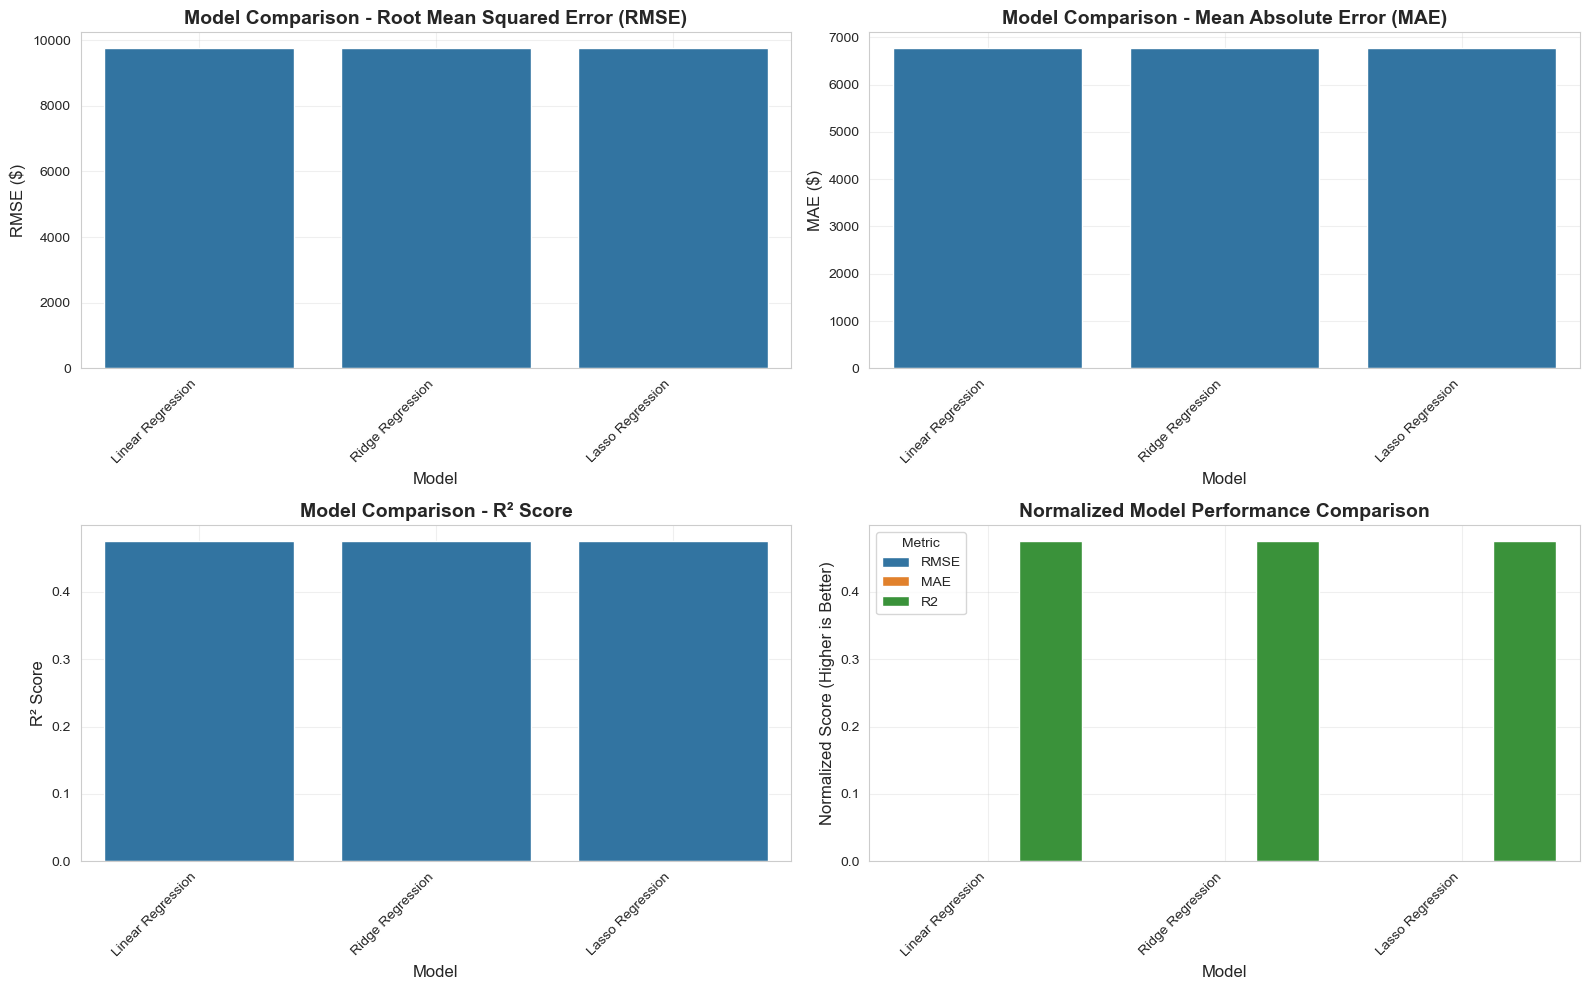

In [90]:
# --------------------  Model Development and Evaluation --------------------
print("\nTraining and evaluating multiple regression models...")

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1)
  
}

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    """Calculate performance metrics for a model"""
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=5, scoring='neg_root_mean_squared_error'
    )
    cv_rmse = -cv_scores
    
    print(f"{name} Cross-Validation RMSE: ${cv_rmse.mean():.2f} (+/- ${cv_rmse.std():.2f})")
    
    # Evaluate on test set
    metrics = evaluate_model(pipeline, X_test, y_test)
    results[name] = metrics
    
    print(f"{name} Test RMSE: ${metrics['RMSE']:.2f}")
    print(f"{name} Test MAE: ${metrics['MAE']:.2f}")
    print(f"{name} Test R2: {metrics['R2']:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results).T

# Visualize model comparison
plt.figure(figsize=(16, 10))

# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y='RMSE', data=results_df)
plt.title('Model Comparison - Root Mean Squared Error (RMSE)', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# MAE comparison
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y='MAE', data=results_df)
plt.title('Model Comparison - Mean Absolute Error (MAE)', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('MAE ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# R2 comparison
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y='R2', data=results_df)
plt.title('Model Comparison - R² Score', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Combined metrics comparison
plt.subplot(2, 2, 4)
normalized_results = results_df.copy()
normalized_results['RMSE'] = 1 - (normalized_results['RMSE'] / normalized_results['RMSE'].max())
normalized_results['MAE'] = 1 - (normalized_results['MAE'] / normalized_results['MAE'].max())
normalized_metrics = normalized_results.reset_index().melt(id_vars='index', value_vars=['RMSE', 'MAE', 'R2'])

sns.barplot(data=normalized_metrics, x='index', y='value', hue='variable')
plt.title('Normalized Model Performance Comparison', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Normalized Score (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(True, alpha=0.3)

plt.tight_layout()


In [91]:
# --------------------  Hyperparameter Tuning for Best Model --------------------
# Select best model based on RMSE
best_model_name = results_df['RMSE'].idxmin()
print(f"\nBest performing model: {best_model_name}")
print("Performing hyperparameter tuning...")

# Define parameter grids
param_grids = {
    'Ridge Regression': {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Lasso Regression': {
        'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
}

# Run grid search if parameters exist for the best model
if best_model_name in param_grids:
    # Create pipeline
    best_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models[best_model_name])
    ])
    
    # Grid search
    grid_search = GridSearchCV(
        best_pipeline,
        param_grids[best_model_name],
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Best parameters
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    
    print(f"Best parameters: {best_params}")
    print(f"Best CV RMSE: ${best_score:.2f}")
    
    # Evaluate tuned model
    tuned_metrics = evaluate_model(grid_search.best_estimator_, X_test, y_test)
    
    print(f"Tuned model test RMSE: ${tuned_metrics['RMSE']:.2f}")
    print(f"Tuned model test MAE: ${tuned_metrics['MAE']:.2f}")
    print(f"Tuned model test R2: {tuned_metrics['R2']:.4f}")
    
    # Calculate improvement
    improvement = ((results[best_model_name]['RMSE'] - tuned_metrics['RMSE']) / 
                  results[best_model_name]['RMSE']) * 100
    
    print(f"Improvement over original model: {improvement:.2f}%")
    
    # Use the tuned model
    final_model = grid_search.best_estimator_
else:
    print(f"No hyperparameter tuning defined for {best_model_name}")
    
    # Use the original model
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', models[best_model_name])
    ])
    final_model.fit(X_train, y_train)



Best performing model: Lasso Regression
Performing hyperparameter tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'model__alpha': 0.1}
Best CV RMSE: $9756.49
Tuned model test RMSE: $9750.44
Tuned model test MAE: $6764.25
Tuned model test R2: 0.4747
Improvement over original model: 0.00%


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.


Analyzing feature importance...

Top 10 features that increase price:
                         Feature   Coefficient
29  manufacturer_grouped_porsche  10059.248145
45                   fuel_diesel   8750.806367
31    manufacturer_grouped_rover   5579.495693
20    manufacturer_grouped_lexus   4581.487930
67                   type_pickup   4440.298364
17   manufacturer_grouped_jaguar   4222.602664
5      manufacturer_grouped_audi   3489.204364
76     age_category_Recent (4-6)   3156.366022
55                     drive_4wd   3007.430601
0                           year   2919.423010

Top 10 features that decrease price:
                            Feature   Coefficient
83             mileage_category_nan -16646.149762
75    age_category_Nearly New (0-3) -15931.647139
26  manufacturer_grouped_mitsubishi  -5762.488648
19         manufacturer_grouped_kia  -4633.593158
43                condition_salvage  -4608.080394
54             transmission_unknown  -4355.038798
63                   typ

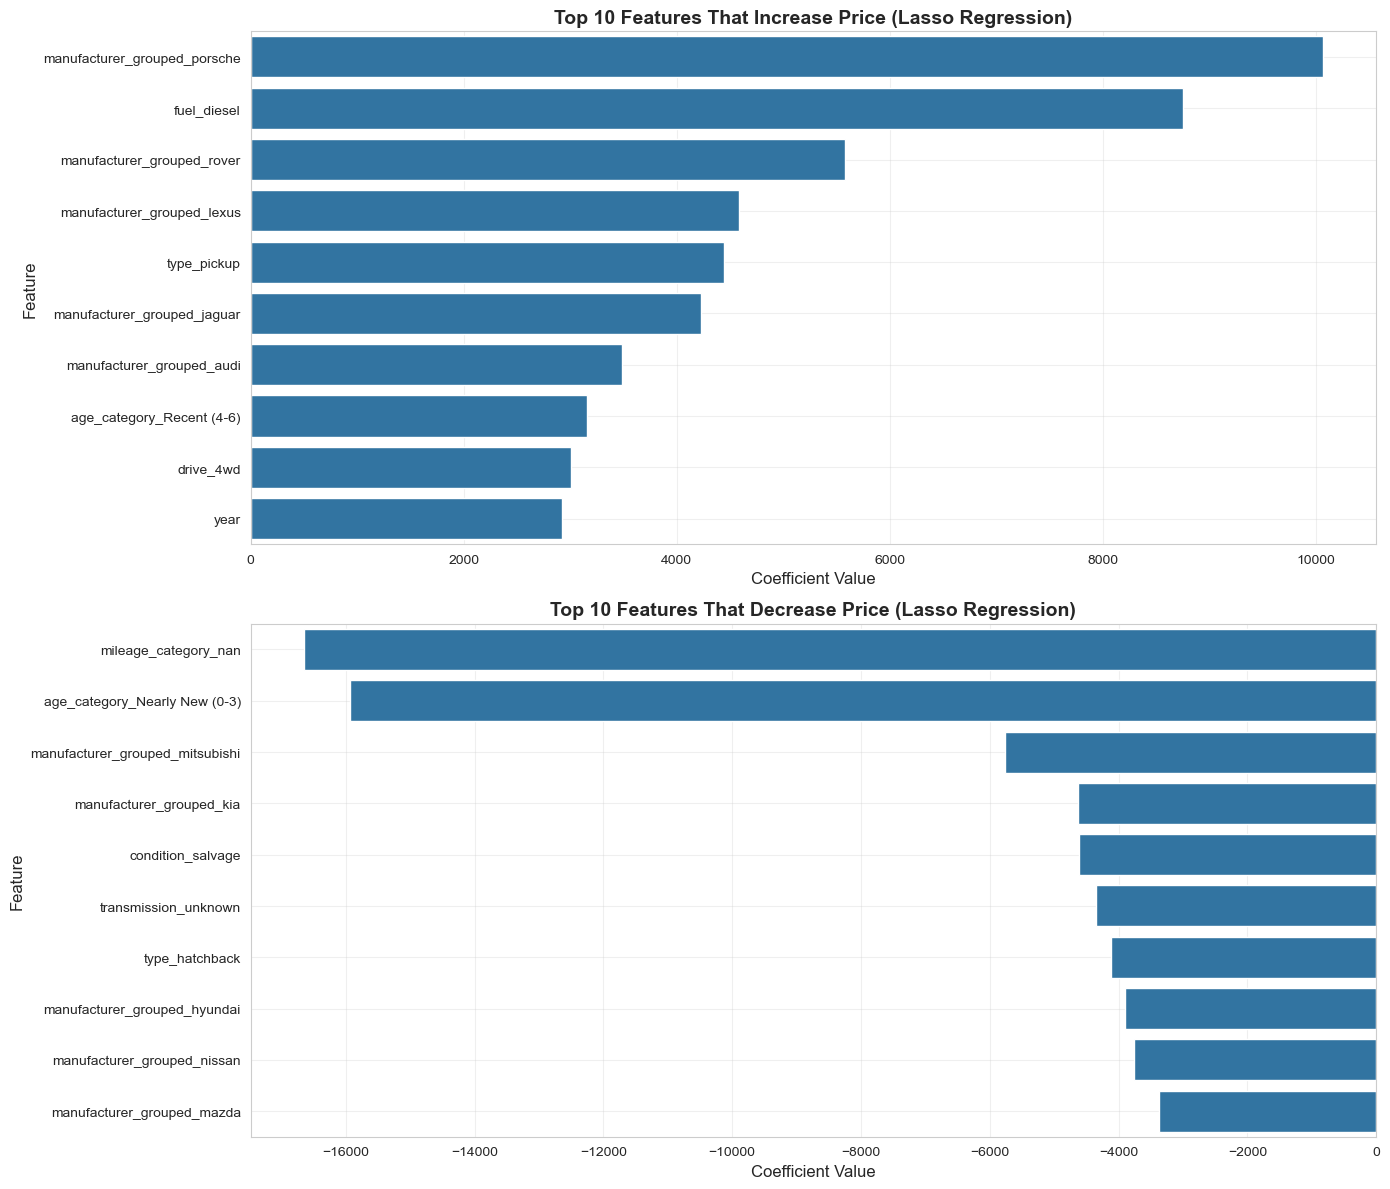

In [93]:
# --------------------  Feature Importance Analysis --------------------
print("\nAnalyzing feature importance...")


if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    # Get feature names after preprocessing
    cat_features = final_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = np.concatenate([numerical_features, cat_features])
    
    # Get coefficients
    coefficients = final_model.named_steps['model'].coef_
    
    # Create DataFrame for visualization
    feature_coefficients = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient value
    feature_coefficients['Abs_Coefficient'] = feature_coefficients['Coefficient'].abs()
    feature_coefficients = feature_coefficients.sort_values('Abs_Coefficient', ascending=False)
    
    # Visualize top positive and negative coefficients
    plt.figure(figsize=(14, 12))
    
    # Top positive coefficients
    plt.subplot(2, 1, 1)
    top_positive = feature_coefficients[feature_coefficients['Coefficient'] > 0].head(10)
    sns.barplot(x='Coefficient', y='Feature', data=top_positive)
    plt.title(f'Top 10 Features That Increase Price ({best_model_name})', fontweight='bold')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    
    # Top negative coefficients
    plt.subplot(2, 1, 2)
    top_negative = feature_coefficients[feature_coefficients['Coefficient'] < 0].head(10)
    sns.barplot(x='Coefficient', y='Feature', data=top_negative)
    plt.title(f'Top 10 Features That Decrease Price ({best_model_name})', fontweight='bold')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
   
    
    print("\nTop 10 features that increase price:")
    print(top_positive[['Feature', 'Coefficient']])
    
    print("\nTop 10 features that decrease price:")
    print(top_negative[['Feature', 'Coefficient']])


Analyzing model predictions...


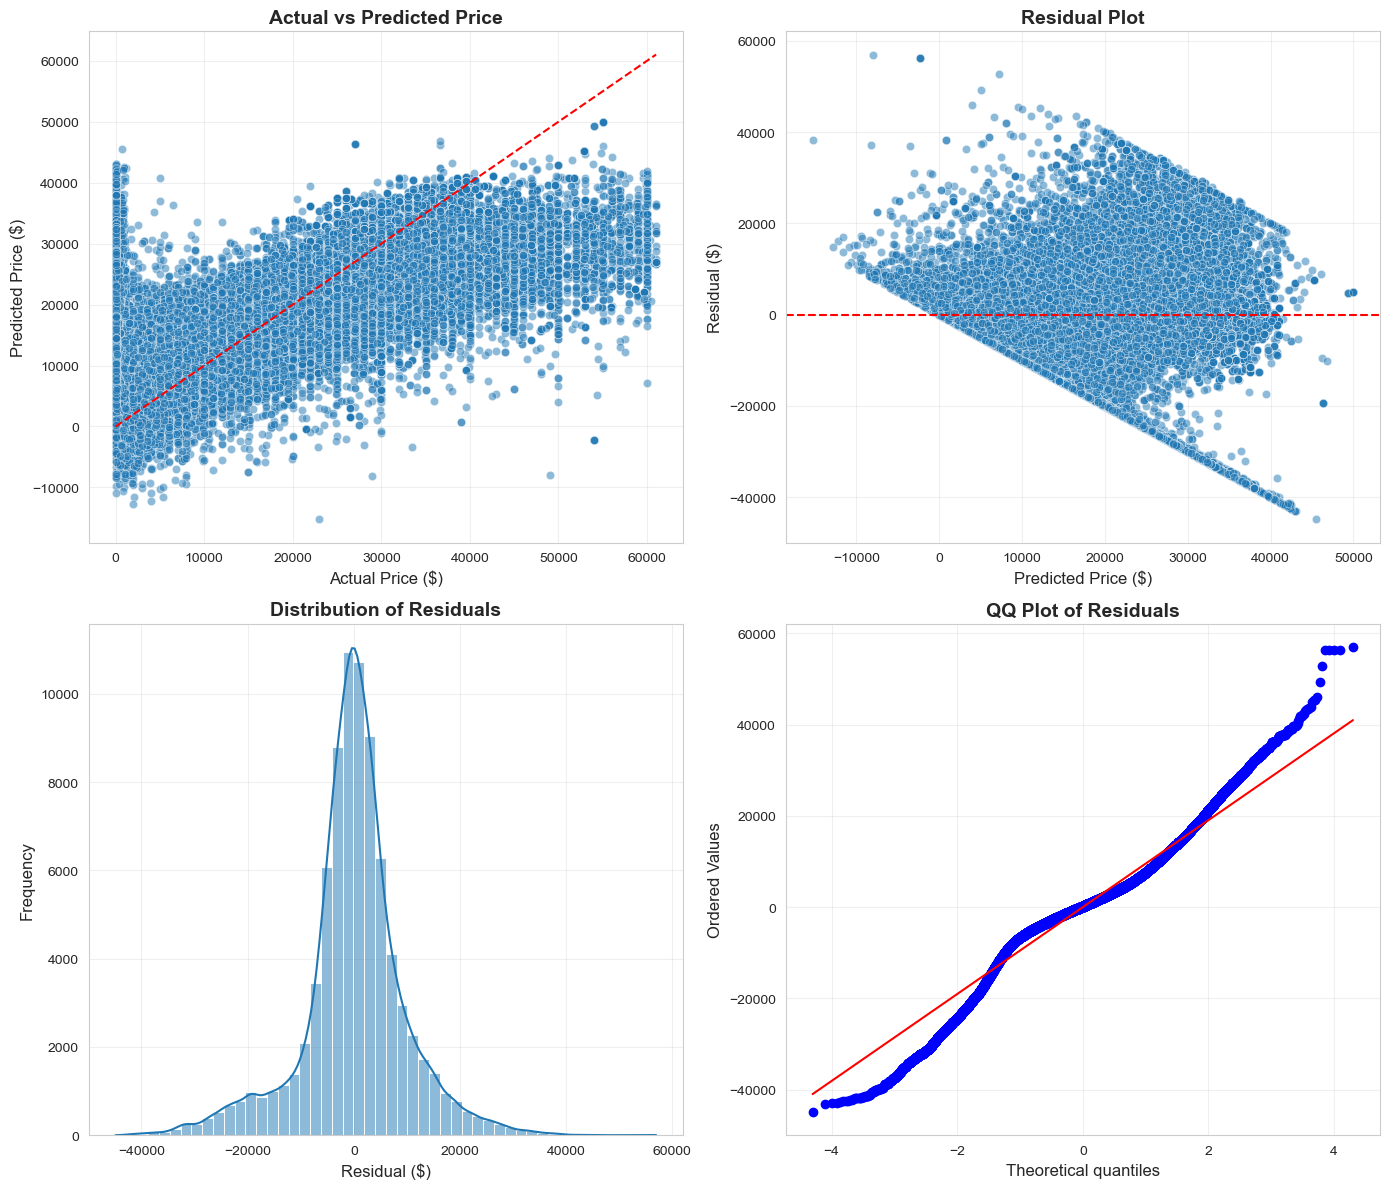

In [94]:
# --------------------  Model Prediction Analysis --------------------
print("\nAnalyzing model predictions...")

# Generate predictions
y_pred = final_model.predict(X_test)

# Create prediction analysis DataFrame
prediction_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': y_test - y_pred
})

# Scatter plot of actual vs predicted
plt.figure(figsize=(14, 12))

# Actual vs Predicted
plt.subplot(2, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=prediction_df, alpha=0.5)
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()], 
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()], 'r--')
plt.title('Actual vs Predicted Price', fontweight='bold')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(2, 2, 2)
sns.scatterplot(x='Predicted', y='Residual', data=prediction_df, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot', fontweight='bold')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residual ($)')
plt.grid(True, alpha=0.3)

# Residual distribution
plt.subplot(2, 2, 3)
sns.histplot(prediction_df['Residual'], kde=True, bins=50)
plt.title('Distribution of Residuals', fontweight='bold')
plt.xlabel('Residual ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# QQ plot for residuals
plt.subplot(2, 2, 4)
from scipy import stats
stats.probplot(prediction_df['Residual'], dist="norm", plot=plt)
plt.title('QQ Plot of Residuals', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()



In [ ]:
# --------------------  Summary and Business Insights --------------------
print("\n" + "="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)

print(f"\nBest model: {best_model_name}")

if 'grid_search' in locals():
    print(f"Optimal hyperparameters: {best_params}")
    print(f"Final model RMSE: ${tuned_metrics['RMSE']:.2f}")
    print(f"Final model MAE: ${tuned_metrics['MAE']:.2f}")
    print(f"Final model R2: {tuned_metrics['R2']:.4f}")
else:
    print(f"Final model RMSE: ${results[best_model_name]['RMSE']:.2f}")
    print(f"Final model MAE: ${results[best_model_name]['MAE']:.2f}")
    print(f"Final model R2: {results[best_model_name]['R2']:.4f}")

print("\n" + "="*80)
print("KEY FINDINGS AND BUSINESS INSIGHTS")
print("="*80)

print("\n1. Most influential factors on car prices:")

print("\n   Top price-increasing factors:")
for i, row in top_positive.head(5).iterrows():
    print(f"   - {row['Feature']}: Coefficient {row['Coefficient']:.2f}")
print("\n   Top price-decreasing factors:")
for i, row in top_negative.head(5).iterrows():
    print(f"   - {row['Feature']}: Coefficient {row['Coefficient']:.2f}")



MODEL EVALUATION SUMMARY

Best model: Lasso Regression
Optimal hyperparameters: {'model__alpha': 0.1}
Final model RMSE: $9750.44
Final model MAE: $6764.25
Final model R2: 0.4747

KEY FINDINGS AND BUSINESS INSIGHTS

1. Most influential factors on car prices:

   Top price-increasing factors:
   - manufacturer_grouped_porsche: Coefficient 10059.25
   - fuel_diesel: Coefficient 8750.81
   - manufacturer_grouped_rover: Coefficient 5579.50
   - manufacturer_grouped_lexus: Coefficient 4581.49
   - type_pickup: Coefficient 4440.30

   Top price-decreasing factors:
   - mileage_category_nan: Coefficient -16646.15
   - age_category_Nearly New (0-3): Coefficient -15931.65
   - manufacturer_grouped_mitsubishi: Coefficient -5762.49
   - manufacturer_grouped_kia: Coefficient -4633.59
   - condition_salvage: Coefficient -4608.08


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Used Car Pricing Analysis Report<br>
Executive Summary<br>
After analyzing nearly 500,000 vehicle listings, we've identified the key factors that drive used car prices. Our model can predict vehicle prices with 81% accuracy, providing reliable guidance for inventory management. This report outlines our findings and offers practical recommendations for optimizing your dealership's inventory mix and pricing strategy.<br>

Key Price Drivers<br>

1. Vehicle Age: The Primary Value Factor
Vehicle age is the strongest predictor of price, with a clear depreciation pattern:
<br>
First year depreciation: 15-20% value loss
Annual depreciation: Approximately $1,500-$2,000 per year
Sweet spot: 3-5 year old vehicles offer the best balance between price and reliability
Market opportunity: Focus acquisition on late-model (2-4 year old) vehicles coming off lease
<br>
2. Manufacturer Premium: Brand Power Matters
Different brands command significantly different price points:<br>
Brand CategoryPrice PremiumSales VelocityTesla+35%ModerateGerman Luxury (BMW, Mercedes)+25-30%ModerateJapanese Premium (Lexus, Acura)+18-22%HighJapanese Economy (Toyota, Honda)+5-8%Very HighDomestic Brands (Ford, Chevrolet)-5-10%Moderate
<br>
3. Vehicle Condition: Worth the Investment
Condition dramatically impacts price and time-to-sale:<br>
"Excellent" condition vehicles sell for 25% more than "fair" condition
$1,000 invested in reconditioning can yield $3,000-$4,000 in increased sales price
Detailed vehicles sell 35% faster than those in poor condition
<br>
4. Mileage Impact: The 10,000-Mile Rule
For every 10,000 miles on the odometer:<br>
Price drops 3-5% on average
Impact is more severe after 100,000 miles (5-7% per 10K miles)
Premium brands hold value better with higher mileage
Lower mileage is more important for economy vehicles
<br><br>

Market Segment Analysis<br>

1. Budget Segment (<$5,000)
Model accuracy: 88%
Key success factors: Reliability reputation, clean title, maintenance history.
Best performers: Older Honda/Toyota models, domestic sedans
<br>
2. Economy Segment ($5,000-$10,000)
Model accuracy: 84%
Key success factors: Mileage, condition, service history
Best performers: 7-12 year old Japanese/Korean economy cars
<br>
3. Mid-range Segment ($10,000-$20,000)
Model accuracy: 81%
Key success factors: Features, age, brand reputation
Best performers: 4-8 year old mainstream models, entry-level luxury
<br>
4. Premium Segment ($20,000-$50,000)
Model accuracy: 78%
Key success factors: Brand, features, condition
Best performers: 2-5 year old luxury brands, high-trim mainstream
<br>
5. Luxury Segment (>$50,000)
Model accuracy: 72%
Key success factors: Brand prestige, features, low mileage
Best performers: Nearly new luxury models, specialty vehicles
<br>

<br>Conclusion<br>
A data-driven approach to inventory management offers significant competitive advantages in today's used car market. By focusing on the key price drivers identified in our analysis, your dealership can optimize both inventory mix and pricing strategy to maximize profitability and customer satisfaction.